# Errors in prediction of Dst from Sub-L1/STEREO-A

This script evaluates the errors in the prediction of Dst from solar wind measurements taken at a point behind in Earth's orbit that experiences the rotation in solar wind streams earlier.

Operations:
1. DATA READING - Reads in STEREO-A and OMNI data.
2. DATA CORRECTIONS - Applies time shift and wind expansion corrections to STEREO-A data.
3. DATA ANALYSIS - Longitudinal dependence, latitudinal dependence, event-based analysis.

In [1]:
# Conda dependencies are listed under environment.yml
import os
import sys
import copy
from datetime import datetime, timedelta
import getpass
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import num2date, date2num
import numpy as np
import pdb
import pickle
import requests
import scipy.io
from scipy import stats
import scipy
import warnings
from sunpy.time import parse_time
import sklearn
import pandas as pd
import matplotlib.dates as mdates
import astropy.units as u
from scipy.optimize import curve_fit, least_squares, minimize
import time
import numba
from numba import jit
from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, HeliocentricEarthEcliptic
import astrospice
from heliocats import data as hd
from predstorm.data import SatData
from predstorm.data import PositionData
import urllib
import multiprocess as mp

import seaborn as sns
from sklearn.metrics import mean_squared_error
from heliocats import plot as hp

#import heliosat
import predstorm as ps
from predstorm import data as pred
#from predstorm.config.conscnts import AU, dist_to_L1
from predstorm.predict import dst_loss_function

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

data_path = '/data/aswo/data/insitu_python/'

/export/home/aswo/eweiler/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function for printing sctistics on dst diffs
def get_sctistics(dst_pred, dst_real, source='L1', printtext=True):
    """Prints some nice sctistics, that's all.
    
    Parameters
    ----------
    dst_pred : np.ndarray
        Array containing predicted Dst values.
    dst_real : np.ndarray
        Array containing real Dst values. Same length as dst_pred.
    source : str (opt, default='L1')
        String to denote source for comparison string prints.
    printtext : bool (opt, default=True)
        If True, prints string summarising scts.
        
    Returns
    -------
    sct_dict : dict
        Dictionary containing values under the keys ['diff_mean', 'diff_std',
        'xcorr', 'ppmc', 'mae', 'rmse']"""

    dst_diff = dst_real - dst_pred
    dst_diff_mean = np.sum(dst_diff) / len(dst_diff)
    dst_diff_std = np.sqrt(np.sum(dst_diff*dst_diff) / len(dst_diff))
    t = np.linspace(0.0, stbh['time'][-1] - stbh['time'][0], len(dst_real), endpoint=False)
    dt = np.linspace(-t[-1], t[-1], 2*len(dst_real)-1)
    xcorr = scipy.signal.correlate(dst_real, dst_pred)
    ppmc = np.corrcoef(dst_real, dst_pred)[0][1]
    mae = np.sum(np.abs(dst_diff)) / len(dst_diff)
    rmse = np.sqrt(mean_squared_error(dst_real, dst_pred))
    if printtext:
        print("DATA FROM {}".format(source))
        print("----------"+'-'*len(source))
        print('Dst diff mean +/- std: {:.2f} +/- {:.2f}'.format(dst_diff_mean, dst_diff_std))
        print("")
        print('Dst obs  mean +/- std: {:.2f} +/- {:.2f}'.format(np.nanmean(dst_real), np.nanstd(dst_real)))
        print('Dst pred mean +/- std: {:.2f} +/- {:.2f}'.format(np.nanmean(dst_pred), np.nanstd(dst_pred)))
        print('Dst obs  min / max: {:.2f} / {:.2f}'.format(np.nanmin(dst_real), np.nanmax(dst_real)))
        print('Dst pred min / max: {:.2f} / {:.2f}'.format(np.nanmin(dst_pred), np.nanmax(dst_pred)))
        print()
        print("Pearson correlation: {:.2f} ".format(ppmc))
        print("Cross-correlation:   {:.1f} hours".format(24.*dt[xcorr.argmax()]))
        print("Mean absolute error: {:.2f} nT".format(mae))
        print("RMSE:                {:.2f} nT".format(rmse))
        print()

    sct_dict = {}
    sct_dict['diff_mean'] = dst_diff_mean
    sct_dict['diff_std'] = dst_diff_std
    sct_dict['xcorr'] = 24.*dt[xcorr.argmax()]
    sct_dict['ppmc'] = ppmc
    sct_dict['mae'] = mae
    sct_dict['rmse'] = rmse

    return sct_dict

## DATA READING

1. Reading in STEREO-A data. SatData objects is stored as pickles to speed up reading time.
2. Read OMNI2 data set.
3. Create persistence model (with 27-day recurrence) from OMNI data.

In [3]:
sc_input = pickle.load(open('data/sta_beacon_gsm.p', 'rb'))

In [4]:
#load Wind data

get_wind = False

if get_wind:
    [wind_input, wind_h] = pickle.load(open(data_path+'wind_1995_now_gse.p', 'rb'))
    scut=np.where(wind_input.time> parse_time('2023-04-01').datetime)[0][0]
    wind_input = wind_input[scut:-1]
    print(wind_h, len(wind_input))

    wind_input = pred.convert_GSE_to_GSM_new(wind_input)
    
    pickle.dump(wind_input, open('data/wind_gsm.p', 'wb'))
    
wind_input = pickle.load(open('data/wind_gsm.p', 'rb'))

In [5]:
# --------------------------------------------------------------------------
# **************************************************************************
#
# Make a SatData Object out of STEREO-A input data
#
# **************************************************************************
# --------------------------------------------------------------------------
# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv


sc_0 = SatData({'time': date2num(sc_input.time),
               'btot': sc_input.bt, 'bx': sc_input.bx, 
               'by': sc_input.by, 'bz': sc_input.bz,
               'speed': sc_input.vt, 'density': sc_input.np, 
               'temp': sc_input.tp}, source='STEREO-A')
Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')

Positions.h['Units'] = 'AU'
Positions.h['ReferenceFrame'] = 'HEEQ'
Positions.h['Observer'] = 'Sun'
sc_0.pos = Positions

sc_0.interp_nans()
#sc_0 = sc_0.make_hourly_data()

sc_0.h['DataSource'] = "STEREO-A Beacon"
sc_0.h['SamplingRate'] = mdates.num2date(sc_0['time'][1]) - mdates.num2date(sc_0['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
sc_0.h['referenceFrame'] = 'GSM'
#sc_0.h['referenceFrame'] = 'GSE'
#stb.h['HeliosatObject'] = STEREO_A
sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

print(sc_0)

Length of data:		475509
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2023-04-01 00:00:00+00:00
Last data point:	2024-02-25 05:08:00+00:00

Header information:
                   DataSource:	STEREO-A Beacon
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	['PLASTIC', 'IMPACT']
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10
               referenceFrame:	GSM
             CoordinateSystem:	rlonlat

Variable statistics:
         VAR        MEAN         STD
       speed      415.81       86.58
     density        2.77        2.12
        temp        0.00        0.00
          bx        0.15        3.91
          by        0.04        4.67
          bz       -0.40        4.06
        btot        6.55        3.32



Text(0, 0.5, 'B$_{z}$ [nT]')

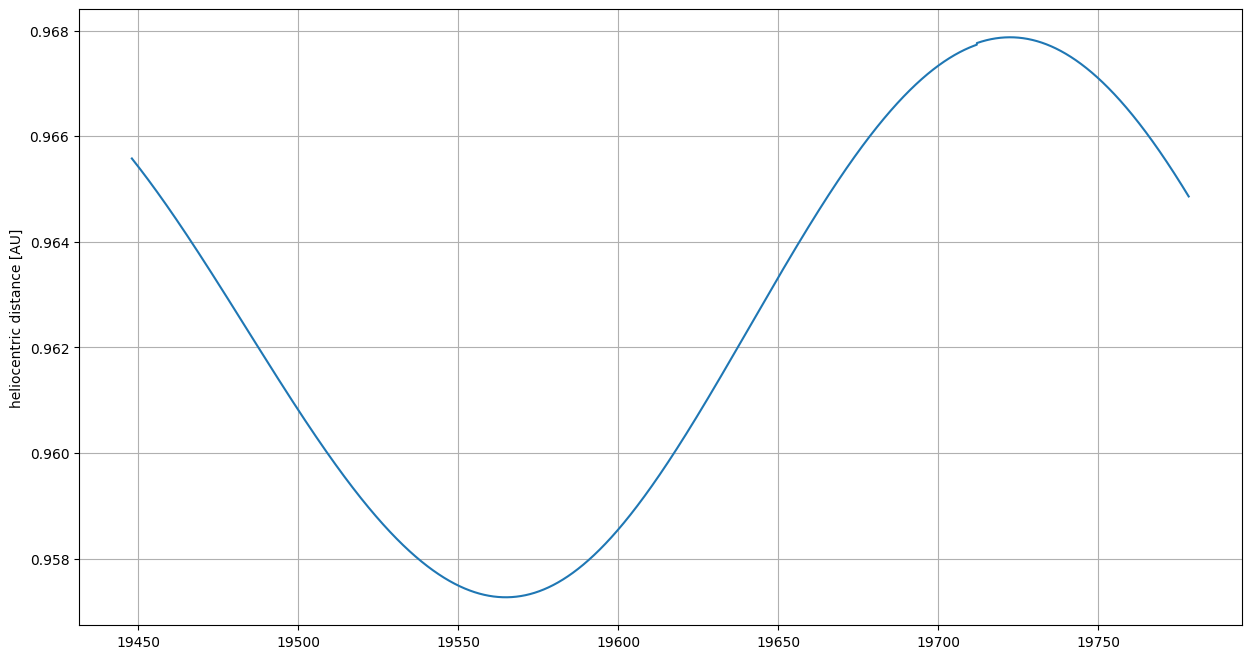

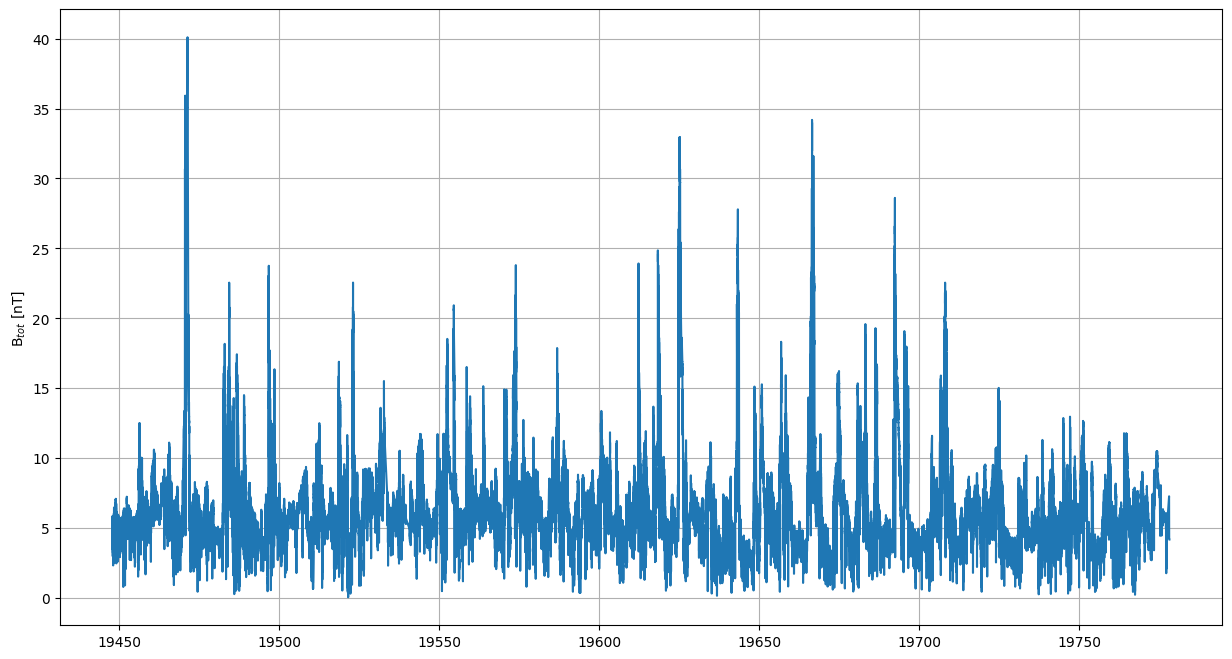

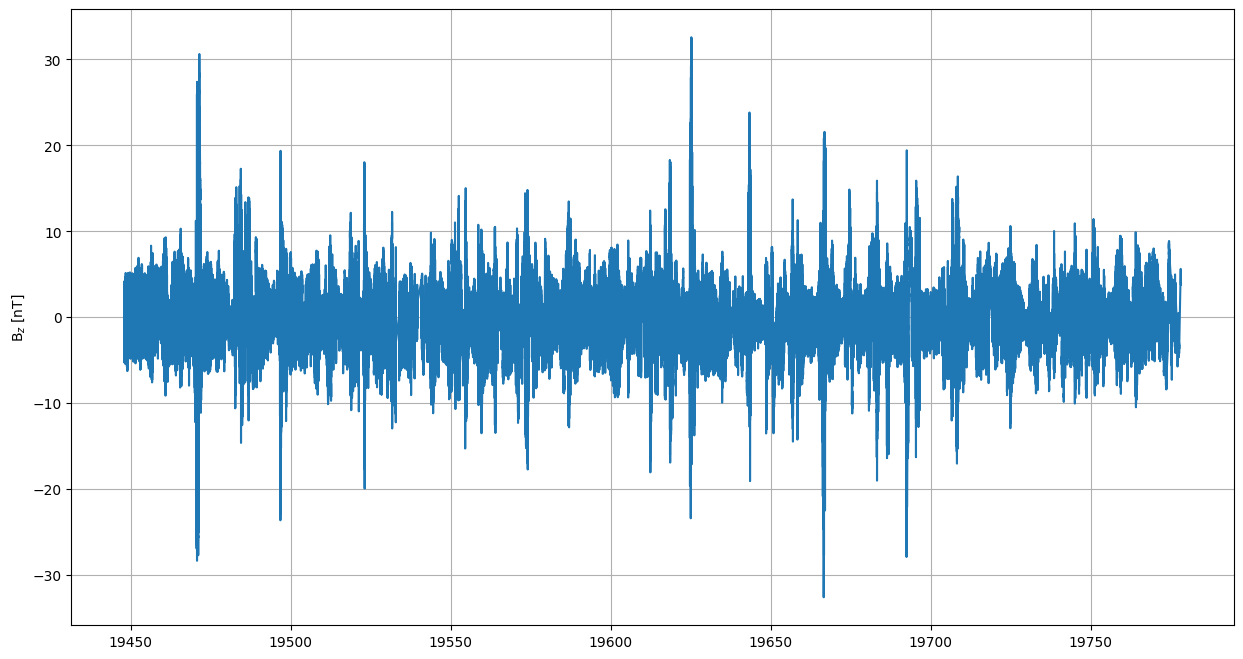

In [6]:
plt.figure(1, figsize=(15,8))
plt.plot(sc_0['time'], sc_0.pos['r'])
plt.ylabel('heliocentric distance [AU]')
plt.grid()
#plt.plot(solo_0['time'], solo_0.pos['r'])
plt.figure(2, figsize=(15,8))
plt.plot(sc_0['time'], sc_0['btot'])
plt.ylabel(r'B$_{tot}$ [nT]')
plt.grid()
plt.figure(3, figsize=(15,8))
plt.plot(sc_0['time'], sc_0['bz'])
plt.grid()
plt.ylabel(r'B$_{z}$ [nT]')

In [7]:
wind_0 = SatData({'time': date2num(wind_input.time),
               'btot': wind_input.bt, 'bx': wind_input.bx, 
               'by': wind_input.by, 'bz': wind_input.bz,
               'speed': wind_input.vt, 'density': wind_input.np, 
               'temp': wind_input.tp}, source='Wind')
Positions = PositionData([wind_input.r, np.deg2rad(wind_input.lon), np.deg2rad(wind_input.lat)], postype='rlonlat')

Positions.h['Units'] = 'AU'
Positions.h['ReferenceFrame'] = 'HEEQ'
Positions.h['Observer'] = 'Sun'
wind_0.pos = Positions

wind_0.interp_nans()
#sc_0 = sc_0.make_hourly_data()

wind_0.h['DataSource'] = "Wind"
wind_0.h['SamplingRate'] = mdates.num2date(wind_0['time'][1]) - mdates.num2date(wind_0['time'][0])
#sc_.h['ReferenceFrame'] = "RTN"
wind_0.h['referenceFrame'] = 'GSM'
#stb.h['HeliosatObject'] = STEREO_A
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
wind_0.h['CoordinateSystem'] = 'xyz'

print(wind_0)

Length of data:		238318
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot']
First data point:	2023-04-01 00:02:00+00:00
Last data point:	2024-02-25 23:56:00+00:00

Header information:
                   DataSource:	Wind
                    SourceURL:	
                 SamplingRate:	0:02:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10
               referenceFrame:	GSM
             CoordinateSystem:	xyz

Variable statistics:
         VAR        MEAN         STD
       speed      418.68       84.46
     density        6.28        4.92
        temp    91846.54   108812.29
          bx        0.59        3.76
          by       -0.08        4.21
          bz       -0.41        3.60
        btot        6.06        3.02



In [8]:
# Test for Chris
'''
wind_orig = copy.deepcopy(wind_0)
wind_new = copy.deepcopy(wind_0)

wind_new['bx'] = wind_orig['bx'] - 1
wind_new['by'] = wind_orig['by'] - 1
wind_new['bz'] = wind_orig['bz'] - 1

print(wind_new)

print(t_start, t_end)
wind_orig.cut(starttime=t_start, endtime=t_end)
wind_new.cut(starttime=t_start, endtime=t_end)

wind_orig['dst'] = wind_orig.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
wind_new['dst'] = wind_new.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(13,12))
fig.suptitle(r'B-components $-1$')
ax1.plot(mdates.num2date(wind_orig['time']), wind_orig['dst'])
ax1.set_ylabel('SYM-H [nT]')
ax2.plot(mdates.num2date(wind_new['time']), wind_new['dst'])
ax2.set_ylabel('SYM-H [nT]')
ax3.plot(mdates.num2date(wind_new['time']), wind_new['dst']-wind_orig['dst'])
ax3.set_ylabel(r'$\Delta$ SYM-H [nT]')
fig.savefig('figures/dst_diff_minus_1.png')
fig.tight_layout()
'''

"\nwind_orig = copy.deepcopy(wind_0)\nwind_new = copy.deepcopy(wind_0)\n\nwind_new['bx'] = wind_orig['bx'] - 1\nwind_new['by'] = wind_orig['by'] - 1\nwind_new['bz'] = wind_orig['bz'] - 1\n\nprint(wind_new)\n\nprint(t_start, t_end)\nwind_orig.cut(starttime=t_start, endtime=t_end)\nwind_new.cut(starttime=t_start, endtime=t_end)\n\nwind_orig['dst'] = wind_orig.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']\nwind_new['dst'] = wind_new.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']\n\nfig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(13,12))\nfig.suptitle(r'B-components $-1$')\nax1.plot(mdates.num2date(wind_orig['time']), wind_orig['dst'])\nax1.set_ylabel('SYM-H [nT]')\nax2.plot(mdates.num2date(wind_new['time']), wind_new['dst'])\nax2.set_ylabel('SYM-H [nT]')\nax3.plot(mdates.num2date(wind_new['time']), wind_new['dst']-wind_orig['dst'])\nax3.set_ylabel(r'$\\Delta$ SYM-H [nT]')\nfig.savefig('figures/dst_diff_minus_1.png')\nfig.tight_layout()\n"

In [9]:
#LOAD OMNI Data

[omni_input, omni_h] = pickle.load(open('omni_high_res.p', 'rb'))
scut_o=np.where(omni_input.time> parse_time('2023-04-01').datetime)[0][0]
omni_input = omni_input[scut_o:-1]
print(omni_h)

omni_0 = SatData({'time': date2num(omni_input.time),
               'symh': omni_input.symh,
               'density': omni_input.np, 
               'temp': omni_input.tp,
               'speed': omni_input.vt,
               'bx': omni_input.bx, 'by': omni_input.by, 'bz': omni_input.bz, 'btot': omni_input.bt}, source='OMNI')


omni_0.h['DataSource'] = "OMNI"
omni_0.h['SamplingRate'] = omni_input['time'][1] - omni_input['time'][0]
omni_0.h['ReferenceFrame'] = "GSM"
omni_0.h['CoordinateSystem'] = 'xyz'

Positions_omni = PositionData([omni_input.r, np.deg2rad(omni_input.lon), np.deg2rad(omni_input.lat)], postype='rlonlat')

#Positions_omni.h['Units'] = 'AU'
#Positions_omni.h['ReferenceFrame'] = 'HEEQ'
#Positions_omni.h['Observer'] = 'Sun'
omni_0.pos = Positions_omni

omni_0.interp_nans()

print(omni_0)

Near Earth OMNI high resolution (1min) solar wind and geomagnetic indices data since 1995. Obtained from https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/omni_min2023.asc  Timerange: 2023-Jan-01 00:00 to 2023-Dec-31 23:59. The data are available in a numpy recarray, fields can be accessed by o.time, o.bx, o.vt etc. Missing data has been set to "np.nan". Total number of data points: 525600. For units and documentation see: https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/modified/hro_modified_format.txt, the heliospheric position of Earth was added and is given in x/y/z/r/lon/lat [AU, degree, HEEQ]. Made with https://github.com/cmoestl/heliocats heliocats.data.save_omni_data .By C. Moestl (twitter @chrisoutofspace), A. J. Weiss, and D. Stansby. File creation date: 2024-Feb-14 11:00 UTC
Length of data:		395998
Keys in data:		['speed', 'density', 'temp', 'bx', 'by', 'bz', 'btot', 'symh']
First data point:	2023-04-01 00:01:00+00:00
Last data point:	2023-12-31 23:58:00+

Text(0, 0.5, 'SYM-H')

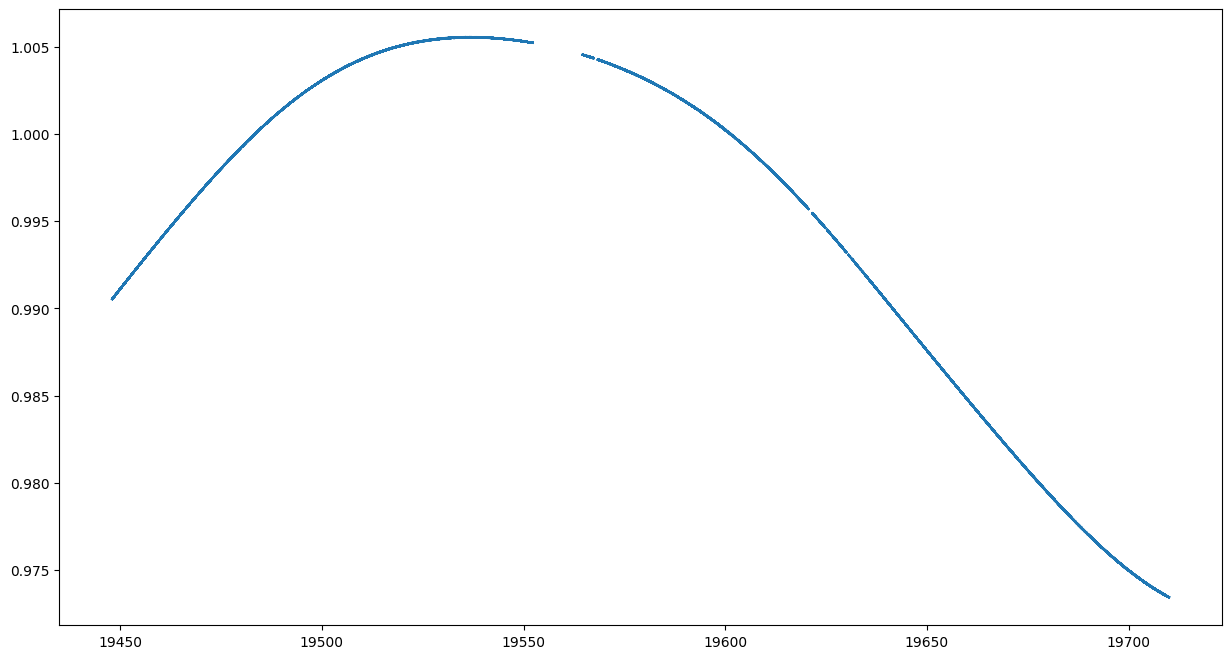

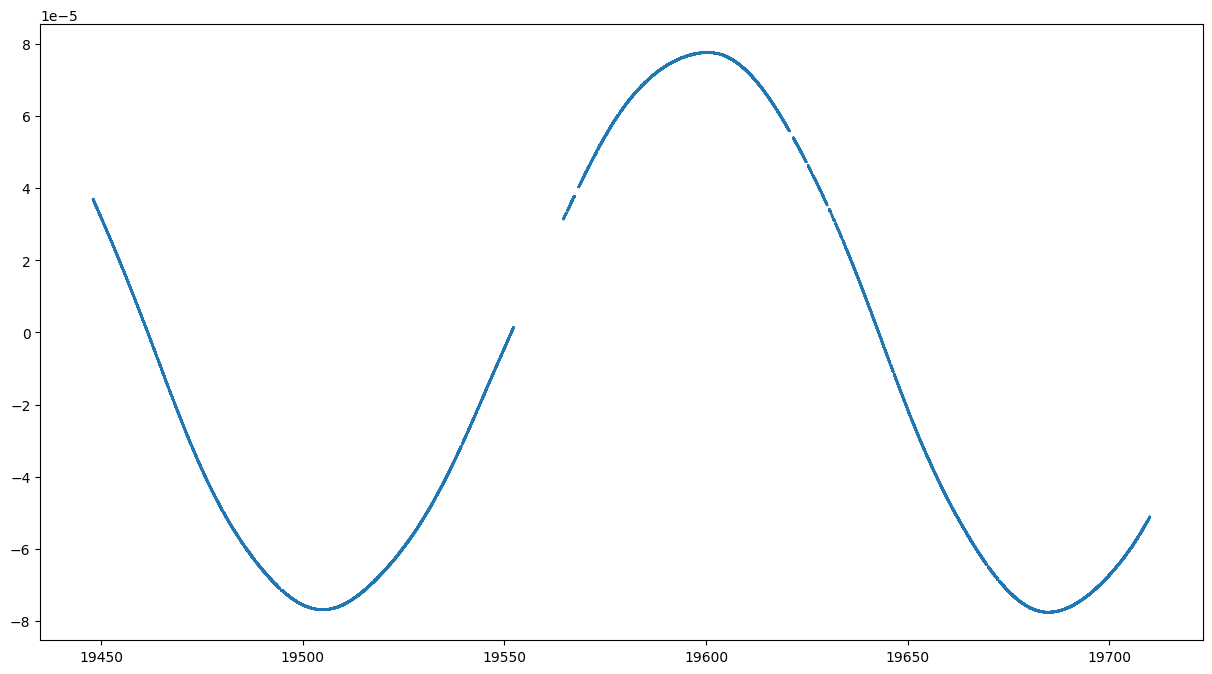

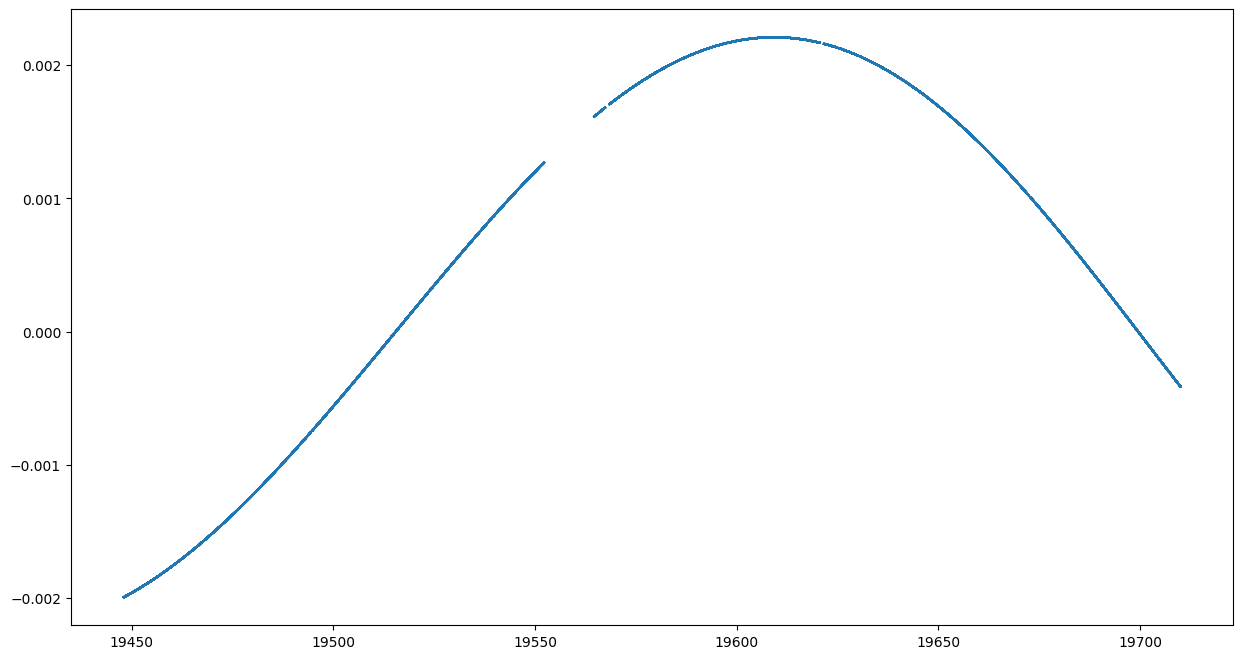

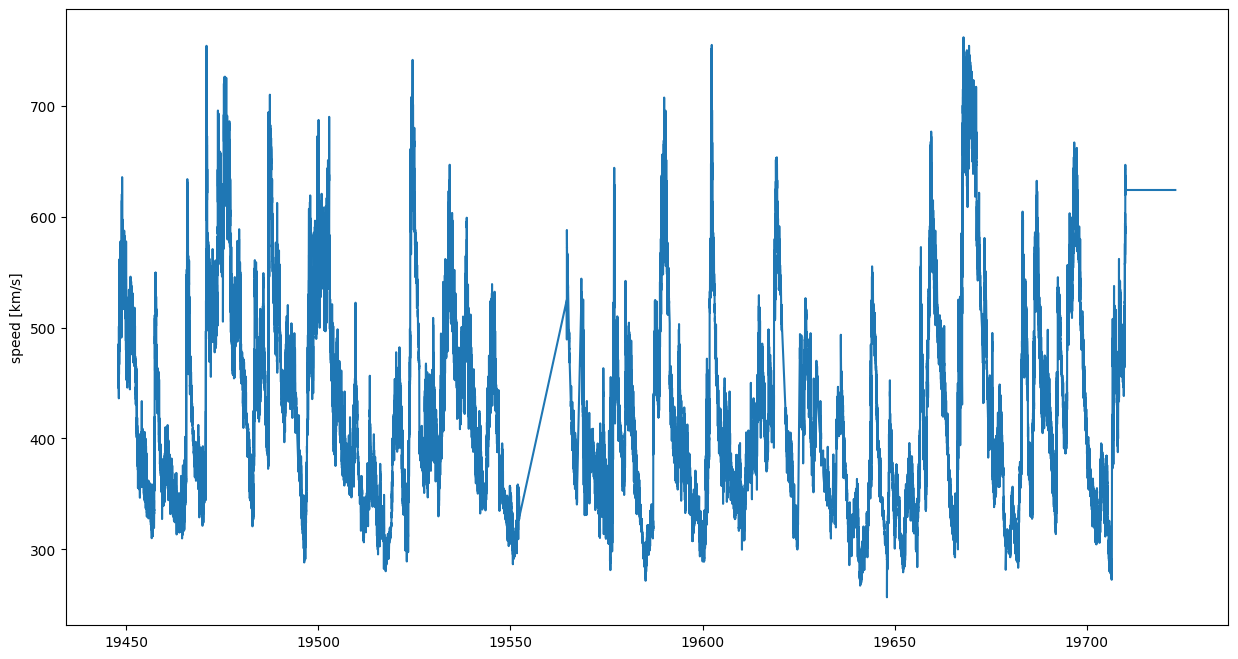

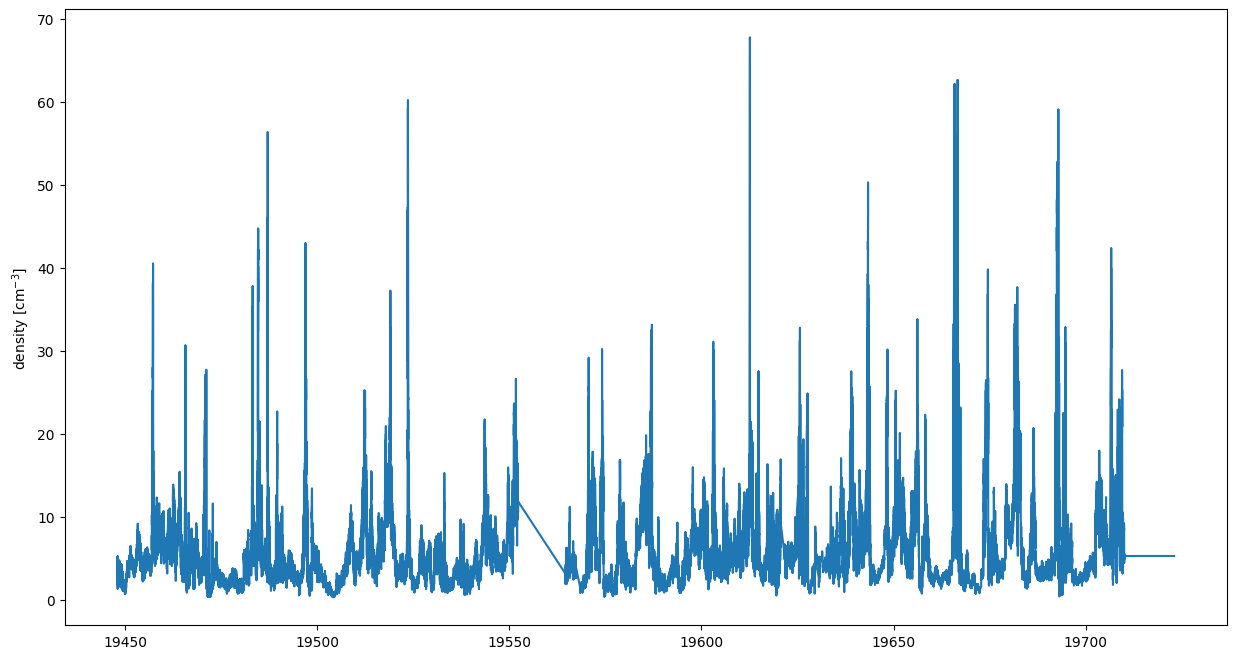

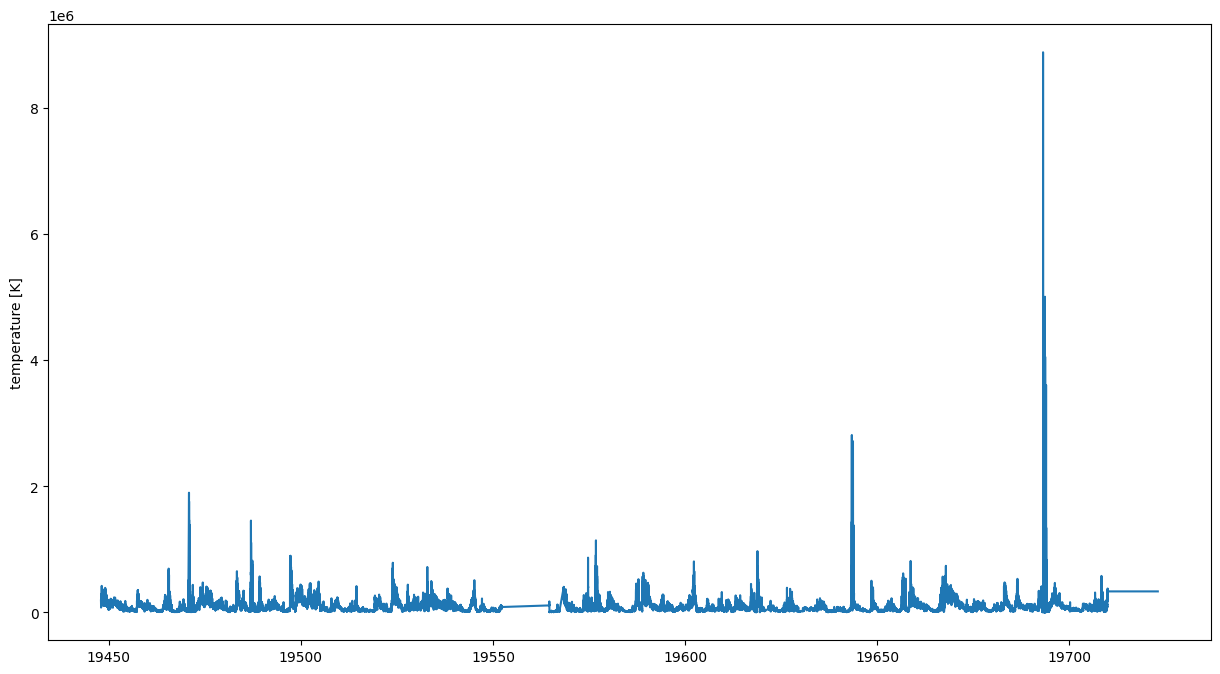

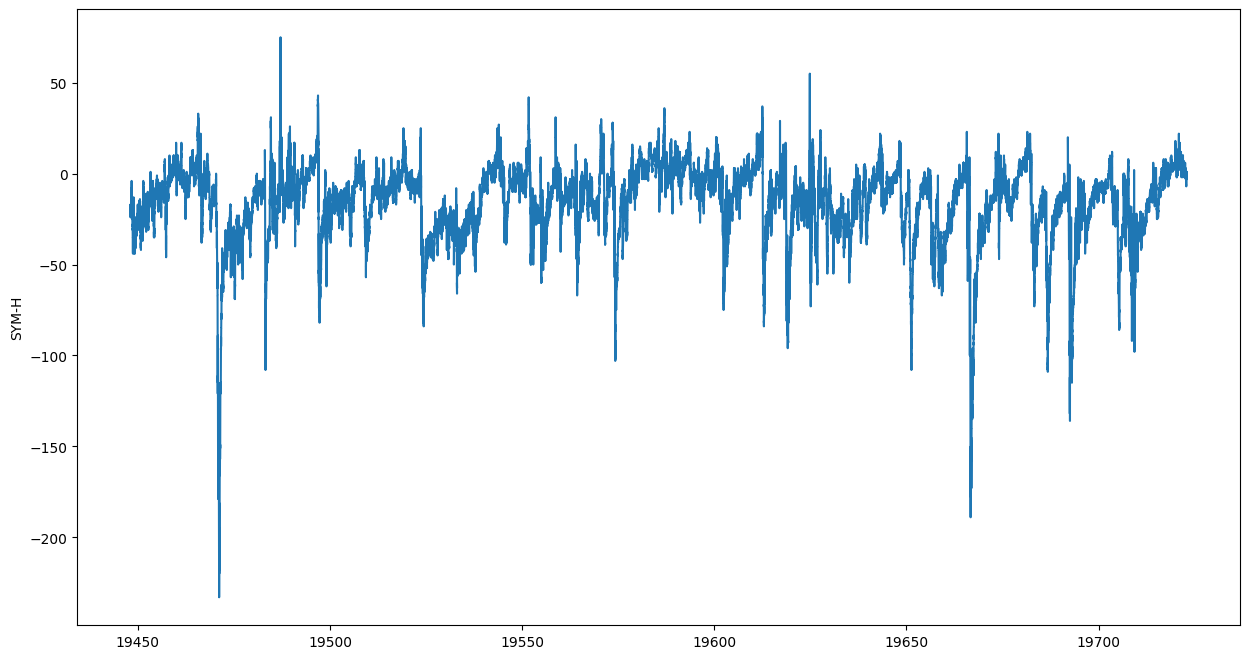

In [10]:
plt.figure(1, figsize=(15,8))
plt.plot(omni_0['time'], omni_0.pos['r'])
plt.figure(2, figsize=(15,8))
plt.plot(omni_0['time'], omni_0.pos['lon'])
plt.figure(3, figsize=(15,8))
plt.plot(omni_0['time'], omni_0.pos['lat'])
#plt.plot(solo_0['time'], solo_0.pos['r'])
plt.figure(4, figsize=(15,8))
plt.plot(omni_0['time'], omni_0['speed'])
plt.ylabel('speed [km/s]')
plt.figure(5, figsize=(15,8))
plt.plot(omni_0['time'], omni_0['density'])
plt.ylabel(r'density [cm$^{-3}$]')
plt.figure(6, figsize=(15,8))
plt.plot(omni_0['time'], omni_0['temp'])
plt.ylabel('temperature [K]')
plt.figure(7, figsize=(15,8))
plt.plot(omni_0['time'], omni_0['symh'])
plt.ylabel('SYM-H')

In [11]:
#get L1 position
get_l1_pos = False

if get_l1_pos == True:
    dt = TimeDelta(1*u.minute)
    frame = HeliographicStonyhurst()
    times_earth = Time(np.arange(Time('2024-1-1'), Time('2024-12-31'), dt))
    coords_earth = astrospice.generate_coords('Earth', times_earth)
    coords_earth = coords_earth.transform_to(frame)

    earth = np.zeros(np.size(times_earth),dtype=[('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    earth = earth.view(np.recarray)
    earth.time = times_earth.to_datetime(leap_second_strict='silent')
    earth.r = coords_earth.radius.to(u.au).value
    earth.lon = coords_earth.lon.value #degrees
    earth.lat = coords_earth.lat.value
    [earth.x, earth.y, earth.z] = hd.sphere2cart(earth.r, np.deg2rad(-earth.lat+90), np.deg2rad(earth.lon))

    l1 = np.zeros(np.size(times_earth),dtype=[('sc', object), ('time',object),('r','f8'),('lon','f8'),('lat','f8'),('x','f8'),('y','f8'),('z','f8')])
    l1 = l1.view(np.recarray)
    l1.sc = 'Wind'
    l1.time = earth.time
    l1.x = earth.x - 1496547.603*u.km.to(u.au)
    l1.y = earth.y
    l1.z = earth.z
    [l1.r, l1_lat, l1_lon] = hd.cart2sphere(l1.x, l1.y, l1.z)
    l1.lat = np.rad2deg(l1_lat)
    l1.lon = np.rad2deg(l1_lon)

    pickle.dump(l1, open('l1_pos_2024.p', 'wb'))

In [12]:
l1 = pickle.load(open('l1_pos_2023.p', 'rb'))

In [13]:
print('load positions')   

#positions needed for arrival time/speed calculation and plotting below
[psp, solo, sta, stereob_recon, bepi, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]=pickle.load( open( data_path+'positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p', "rb" ) )

print('done')

load positions
done


In [14]:
### Load DONKI to use DONKI-ID for updating initial parameters for ELEvo

date=datetime(2023,1,1).strftime('%Y-%m-%d')#(datetime.now()-timedelta(days=10)).strftime('%Y-%m-%d')

download_donki = False

if download_donki:
    url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+date
    try: urllib.request.urlretrieve(url_donki,'data/DONKI.json')
    except urllib.error.URLError as e:
        print('DONKI not loaded')
    
data_donki = pd.read_json('data/DONKI.json')
data_donki['time21_5'] = mdates.date2num(data_donki.time21_5)
data_donki = data_donki.groupby('associatedCMEID').mean().reset_index()

print('# CMEs since beginning of 2023: ', len(data_donki))

# CMEs since beginning of 2023:  1224


In [15]:
index = np.where(data_donki["associatedCMEID"].str.contains("2023-04-21T18:12:00-CME-001"))[0][0]

#index = np.where(data_donki.associatedCMEID[data_donki.associatedCMEID == '2023-04-21T18:12:00-CME-001'])[0][0]
print(index)
sc_icme_start_time = datetime(2023,4,23,14,29)
measured_time_shift = 2.55

372


In [16]:
#### Update initial parameter for ELEvo according to actual arrival time of CME ###

sc_measure_name = 'STEREO-A'

print('Sub-L1 monitor s/c: ', sc_measure_name)

distance0 = 21.5*u.solRad.to(u.km)

t0_num = data_donki.time21_5[index]
t0 = mdates.num2date(t0_num)

print('Launch time (21.5 R_Sun): ', t0)
print('Start ICME @ STEREO-A: ', sc_icme_start_time)

longitude = 0. #data_donki.longitude[index]
gamma_init = 0.1                  
ambient_wind_init = 400
speed_init = data_donki.speed[index]
x0 = [speed_init, ambient_wind_init, gamma_init]
print('Initial Parameters (DONKI): ', gamma_init, ambient_wind_init, speed_init)

kindays = 10
n_ensemble = 50000
halfwidth = np.deg2rad(35.)
res_in_min = 10
f = 0.7

if sc_measure_name == 'PSP':
    sc_measure = psp
if sc_measure_name == 'SolarOrbiter':
    sc_measure = solo
if sc_measure_name == 'STEREO-A':
    sc_measure = sta
if sc_measure_name == 'BepiColombo':
    sc_measure = bepi
if sc_measure_name == 'Wind':
    sc_measure = wind

sc_ind_measure = np.argmin(np.abs(t0_num-sc_measure.time))
    

index_sc_heliodistance = np.argmin(np.abs(mdates.date2num(sc_icme_start_time)-sc_measure.time))
cme_prop_time = (parse_time(sc_icme_start_time)-parse_time(mdates.num2date(data_donki.time21_5[index]))).sec

if np.abs(np.deg2rad(longitude)) + np.abs(sc_measure.lon[index_sc_heliodistance]) > np.pi and np.sign(np.deg2rad(longitude)) != np.sign(sc_measure.lon[index_sc_heliodistance]): 
    delta_sc_measure = np.deg2rad(longitude) - (sc_measure.lon[index_sc_heliodistance] + 2 * np.pi * np.sign(np.deg2rad(longitude)))

else:
    delta_sc_measure = np.deg2rad(longitude) - sc_measure.lon[index_sc_heliodistance]

    
def cme_r_prop(x, time_diff, distance0=distance0):
    if x[0] >= x[1]:
        accsign = 1.

    else:
        accsign = -1.

    rdrag = (accsign / (x[2] * 1e-7)) * np.log(1 + (accsign * x[2] * 1e-7) * ((x[0] - x[1]) * time_diff)) + x[1] * time_diff + distance0
    vdrag = (x[0] - x[1]) / (1 + (accsign * (x[2] * 1e-7) * (x[0] - x[1]) * time_diff)) + x[1]

    return rdrag, vdrag

rdrag, vdrag = cme_r_prop(x0, cme_prop_time)


def rmse(x, time_diff=cme_prop_time, r_sc=sc_measure.r[index_sc_heliodistance], cme_delta=delta_sc_measure): #v_sc=speed_ic, 

    if x[0] >= x[1]:
        accsign = 1.

    else:
        accsign = -1.

    r_at_sc = (accsign / (x[2] * 1e-7)) * np.log(1 + (accsign * x[2] * 1e-7) * ((x[0] - x[1]) * time_diff)) + x[1] * time_diff + distance0
    #v_at_sc= (x[2] - x[1]) / (1 + (accsign * (x[2] * 1e-7) * (x[0] - x[1]) * time_diff)) + x[1]

    cme_r_au = r_at_sc*u.km.to(u.au)

    theta_monitor = np.arctan(f**2 * np.tan(halfwidth))
    omega_monitor = np.sqrt(np.cos(theta_monitor)**2 * (f**2 - 1) + 1)   
    cme_b_monitor = cme_r_au * omega_monitor * np.sin(halfwidth) / (np.cos((halfwidth) - theta_monitor) + omega_monitor * np.sin(halfwidth))    
    cme_a_monitor = cme_b_monitor / f
    cme_c_monitor = cme_r_au - cme_b_monitor

    root = np.sin(cme_delta)**2 * f**2 * (cme_b_monitor**2 - cme_c_monitor**2) + np.cos(cme_delta)**2 * cme_b_monitor**2
    discnce_sc_monitor = (cme_c_monitor * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2 + np.cos(cme_delta)**2)

    rmse = np.sqrt((r_sc - discnce_sc_monitor)**2)

    return rmse

params_opt = minimize(rmse, x0, bounds=((0, None), (0, None), (0, None)), method='Nelder-Mead')

print('Optimization message: ', params_opt.message)

parameter = [params_opt.x[0], params_opt.x[1], params_opt.x[2]]
print('Initial Parameters [inital CME speed, ambient wind, gamma]: ', x0)
print('Optimized Parameters [inital CME speed, ambient wind, gamma]: ', parameter)

gamma_update = params_opt.x[2]
ambient_wind_update = params_opt.x[1]
speed_update = params_opt.x[0]

def check(x, time_diff=cme_prop_time, cme_delta=delta_sc_measure): #v_sc=speed_ic, 

    r_at_sc, v_at_sc = cme_r_prop(x, cme_prop_time)

    cme_r_au = r_at_sc*u.km.to(u.au)
    cme_v_au = v_at_sc

    theta_monitor = np.arctan(f**2 * np.tan(halfwidth))
    omega_monitor = np.sqrt(np.cos(theta_monitor)**2 * (f**2 - 1) + 1)   
    cme_b_monitor = cme_r_au * omega_monitor * np.sin(halfwidth) / (np.cos((halfwidth) - theta_monitor) + omega_monitor * np.sin(halfwidth))    
    cme_a_monitor = cme_b_monitor / f
    cme_c_monitor = cme_r_au - cme_b_monitor

    root = np.sin(cme_delta)**2 * f**2 * (cme_b_monitor**2 - cme_c_monitor**2) + np.cos(cme_delta)**2 * cme_b_monitor**2
    distance_sc_monitor = (cme_c_monitor * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2 + np.cos(cme_delta)**2)

    return distance_sc_monitor, cme_v_au, cme_r_au

check_distance, velocity_at_sc, apex_distance = check(x=parameter)
velocity = velocity_at_sc
print('Actual position of sub-L1 monitor: ', sc_measure.r[index_sc_heliodistance])
print('Calculated distance, where CME hits STEREO-A, and apex distance using updated paramters: ', check_distance, apex_distance)
print('Velocity @STEREO-A without update: ', vdrag)
print('Velocity @STEREO-A with updated parameters: ', velocity_at_sc)
print(' ')


Sub-L1 monitor s/c:  STEREO-A
Launch time (21.5 R_Sun):  2023-04-21 21:09:00+00:00
Start ICME @ STEREO-A:  2023-04-23 14:29:00
Initial Parameters (DONKI):  0.1 400 1204.0
Optimization message:  Optimization terminated successfully.
Initial Parameters [inital CME speed, ambient wind, gamma]:  [1204.0, 400, 0.1]
Optimized Parameters [inital CME speed, ambient wind, gamma]:  [1116.7134832872798, 399.199689079187, 0.1067554051546597]
Actual position of sub-L1 monitor:  0.9636429812440627
Calculated distance, where CME hits STEREO-A, and apex distance using updated paramters:  0.9636429812440639 0.9733783242918883
Velocity @STEREO-A without update:  766.0615420479048
Velocity @STEREO-A with updated parameters:  734.5201474028391
 


In [17]:
today = datetime.today()
date_today = datetime.now().strftime('%Y-%m-%d')
#date_today_hours = datetime.now().strftime('%Y-%m-%d_%H')
date_today_minutes = datetime.now().strftime('%Y-%m-%d %H:%M')

header = r'ID, time 21.5 [UT, at 21.5 R_Sun], lon [deg], lat [deg], initial speed [km/s], arrival time [UT], error arrival time [h], arrival speed [km/s], error arrival speed [km/s]'
with open('output/icme_arrival.txt', "a") as f:
    f.write('ASWO, GeoSphere Austria - created ' + str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC \n')
    f.write(header + '\n')
    f.close
    
header = r'ID, time 21.5 [UT, at 21.5 R_Sun], lon [deg], lat [deg], initial speed [km/s], arrival time [UT], error arrival time [h], arrival speed [km/s], error arrival speed [km/s]'
with open('output/icme_arrival_stereoa.txt', "a") as f:
    f.write('ASWO, GeoSphere Austria - created ' + str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC \n')
    f.write(header + '\n')
    f.close

In [18]:
gamma_init = [0.1, gamma_update]
ambient_wind_init = [400., ambient_wind_update]
speed_init = [data_donki.speed[index], speed_update]

def donki_kinematics(i):
    
    print('Processing CME ', i+1)
    
    #index = data_donki.associatedCMEID[data_donki.associatedCMEID == '2023-04-21T18:12:00-CME-001'].index[0]
    distance0 = 21.5*u.solRad.to(u.km)
    t0_num = data_donki.time21_5[index]
    t0 = mdates.num2date(t0_num)
    longitude = 1. #data_donki.longitude[index]
    kindays = 15
    n_ensemble = 100000
    halfwidth = np.deg2rad(35.)
    #halfwidth = np.deg2rad(data_donki.halfAngle[index])
    #print(np.rad2deg(halfwidth))
    res_in_min = 10
    f = 0.7
    kindays_in_min = int(kindays*24*60/res_in_min)

    #for sc in ['earth', 'sta']:
    
    dct = t0_num-wind.time
    wind_ind = np.argmin(np.abs(dct))
    
        
    t0_num_kindays = mdates.date2num(mdates.num2date(t0_num)+timedelta(days=kindays))
    dct0 = t0_num_kindays-wind.time
    wind_ind2 = np.argmin(np.abs(dct0))
        
    dct1 = t0_num-sta.time
    sta_ind = np.argmin(np.abs(dct1))
    
    dct2 = t0_num_kindays-sta.time
    sta_ind2 = np.argmin(np.abs(dct2))

    
    delta_wind_list = []
    for j in range(kindays_in_min):
        if np.abs(np.deg2rad(longitude)) + np.abs(wind.lon[wind_ind+j:wind_ind+(j+1)]) > np.pi and np.sign(np.deg2rad(longitude)) != np.sign(wind.lon[wind_ind+j:wind_ind+(j+1)]):
            delta_wind = (np.deg2rad(longitude) - (wind.lon[wind_ind+j:wind_ind+(j+1)] + 2 * np.pi * np.sign(np.deg2rad(longitude))))[0]

        else:
            delta_wind = (np.deg2rad(longitude) - wind.lon[wind_ind+j:wind_ind+(j+1)])[0]
        
        delta_wind_list.append(delta_wind)
    
    
    delta_sta_list = []
    for j in range(kindays_in_min):
        if np.abs(np.deg2rad(longitude)) + np.abs(sta.lon[sta_ind+j:sta_ind+(j+1)]) > np.pi and np.sign(np.deg2rad(longitude)) != np.sign(sta.lon[sta_ind+j:sta_ind+(j+1)]):
            delta_sta = (np.deg2rad(longitude) - (sta.lon[sta_ind+j:sta_ind+(j+1)] + 2 * np.pi * np.sign(np.deg2rad(longitude))))[0]

        else:
            delta_sta = (np.deg2rad(longitude) - sta.lon[sta_ind+j:sta_ind+(j+1)])[0]
            
        delta_sta_list.append(delta_sta)
    
    #times for each event kinematic
    time1=[]
    tstart1=copy.deepcopy(t0)
    tend1=tstart1+timedelta(days=kindays)
    #make 30 min datetimes
    while tstart1 < tend1:

        time1.append(tstart1)  
        tstart1 += timedelta(minutes=res_in_min)    

    #make kinematics
    
    timestep=np.zeros([kindays_in_min,n_ensemble])
    cme_r=np.zeros([kindays_in_min, 3])
    cme_v=np.zeros([kindays_in_min, 3])
    cme_lon=np.ones(kindays_in_min)*1#longitude
    cme_lat=np.ones(kindays_in_min)*data_donki.latitude[index]
    cme_id=np.chararray(kindays_in_min, itemsize=27)
    cme_id[:]=data_donki.associatedCMEID[index]
    cme_r_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_v_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_delta = [[x] * 3 for x in delta_wind_list]
    cme_delta_sta = [[x] * 3 for x in delta_sta_list]
    cme_hit=np.zeros(kindays_in_min)
    cme_hit[np.abs(delta_wind_list[0])<halfwidth] = 1
    cme_hit_sta=np.zeros(kindays_in_min)
    cme_hit_sta[np.abs(delta_sta_list[0])<halfwidth] = 1
    distance_wind = np.empty([kindays_in_min,3])
    distance_sta = np.empty([kindays_in_min,3])
    distance_wind[:] = np.nan
    distance_sta[:] = np.nan
   
    gamma = np.abs(np.random.normal(gamma_init[i],0.025,n_ensemble))
    ambient_wind = np.random.normal(ambient_wind_init[i],50,n_ensemble)
    speed = np.random.normal(speed_init[i],50,n_ensemble)
    
    timesteps = np.arange(kindays_in_min)*res_in_min*60
    timesteps = np.vstack([timesteps]*n_ensemble)
    timesteps = np.transpose(timesteps)

    accsign = np.ones(n_ensemble)
    accsign[speed < ambient_wind] = -1.

    distance0_list = np.ones(n_ensemble)*distance0
    
    cme_r_ensemble = (accsign / (gamma * 1e-7)) * np.log(1 + (accsign * (gamma * 1e-7) * ((speed - ambient_wind) * timesteps))) + ambient_wind * timesteps + distance0_list
    cme_v_ensemble = (speed - ambient_wind) / (1 + (accsign * (gamma * 1e-7) * (speed - ambient_wind) * timesteps)) + ambient_wind

    cme_r_mean = cme_r_ensemble.mean(1)
    cme_r_std = cme_r_ensemble.std(1)
    cme_v_mean = cme_v_ensemble.mean(1)
    cme_v_std = cme_v_ensemble.std(1)
    cme_r[:,0]= cme_r_mean*u.km.to(u.au)
    cme_r[:,1]=(cme_r_mean - 2*cme_r_std)*u.km.to(u.au) 
    cme_r[:,2]=(cme_r_mean + 2*cme_r_std)*u.km.to(u.au)
    cme_v[:,0]= cme_v_mean
    cme_v[:,1]=(cme_v_mean - 2*cme_v_std)
    cme_v[:,2]=(cme_v_mean + 2*cme_v_std)
    
    #Ellipse parameters   
    theta = np.arctan(f**2*np.ones([kindays_in_min,3]) * np.tan(halfwidth*np.ones([kindays_in_min,3])))
    omega = np.sqrt(np.cos(theta)**2 * (f**2*np.ones([kindays_in_min,3]) - 1) + 1)   
    cme_b = cme_r * omega * np.sin(halfwidth*np.ones([kindays_in_min,3])) / (np.cos(halfwidth*np.ones([kindays_in_min,3]) - theta) + omega * np.sin(halfwidth*np.ones([kindays_in_min,3])))    
    cme_a = cme_b / f*np.ones([kindays_in_min,3])
    cme_c = cme_r - cme_b
        
    root = np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta)**2 * cme_b**2
    
    distance_wind[cme_hit.all() == 1] = (cme_c * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta)**2) #distance from SUN in AU for given point on ellipse
    
    
    root_sta = np.sin(cme_delta_sta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta_sta)**2 * cme_b**2
    distance_sta[cme_hit_sta.all() == 1] = (cme_c * np.cos(cme_delta_sta) + np.sqrt(root_sta)) / (np.sin(cme_delta_sta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta_sta)**2) 
    

    arr_time = []
    arrival = []
    arr_time_fin = []
    arr_time_err = []
    arr_time_err0 = []
    arr_time_err1 = []
    arr_speed_fin = []
    arr_speed_err = []
    arr_id = []
    arr_hit = []
    if np.isnan(distance_wind).all() == False:

        for t in range(3):
            index_wind = np.argmin(np.abs(np.ma.array(distance_wind[:,t], mask=np.isnan(distance_wind[:,t])) - wind.r[wind_ind:wind_ind2])) 
            arr_time.append(time1[int(index_wind)])
        
        arr_speed = cme_v[:,0][index_wind]
        err_arr_speed = cme_v[:,2][index_wind]-cme_v[:,1][index_wind]
        err_arr_time = (arr_time[1]-arr_time[2]).total_seconds()/3600.   
        arrival.append([cme_id[0].decode("utf-8"), t0.strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(speed_init[i]), arr_time[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time), "{:.2f}".format(arr_speed), "{:.2f}".format(err_arr_speed)])   
        arr_time_fin.append(arr_time[0])
        arr_time_err.append(err_arr_time)
        arr_time_err0.append(arr_time[0]-timedelta(hours=err_arr_time))
        arr_time_err1.append(arr_time[0]+timedelta(hours=err_arr_time))
        arr_speed_fin.append(arr_speed)
        arr_speed_err.append(err_arr_speed)
        arr_id.append(cme_id[0].decode("utf-8"))
        arr_hit.append(1.)
        
    else:
        arr_time_fin.append(np.nan)
        arr_time_err0.append(np.nan)
        arr_time_err1.append(np.nan)
        arr_speed_fin.append(np.nan)
        arr_speed_err.append(np.nan)
        arr_id.append(np.nan)
        arr_hit.append(np.nan)
    
    print(arr_time_fin)
    print(arr_speed_fin)
        
    arr_time_sta = []
    arrival_sta = []
    arr_time_fin_sta = []
    arr_time_err0_sta = []
    arr_time_err1_sta = []
    arr_id_sta = []
    arr_hit_sta = []
    if np.isnan(distance_sta).all() == False:

        for t in range(3):
           
            index_sta = np.argmin(np.abs(np.ma.array(distance_sta[:,t], mask=np.isnan(distance_sta[:,t])) - sta.r[sta_ind:sta_ind2]))            
            arr_time_sta.append(time1[int(index_sta)])
        
        arr_speed_sta = cme_v[:,0][index_sta]
        err_arr_speed_sta = cme_v[:,2][index_sta]-cme_v[:,1][index_sta]
        err_arr_time_sta = (arr_time_sta[1]-arr_time_sta[2]).total_seconds()/3600.   
        arrival_sta.append([cme_id[0].decode("utf-8"), t0.strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(speed_init[i]), arr_time_sta[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time_sta), "{:.2f}".format(arr_speed_sta), "{:.2f}".format(err_arr_speed_sta)])             
        arr_time_fin_sta.append(arr_time_sta[0])
        arr_time_err0_sta.append(arr_time[0]-timedelta(hours=err_arr_time_sta))
        arr_time_err1_sta.append(arr_time[0]+timedelta(hours=err_arr_time_sta))
        arr_id_sta.append(cme_id[0].decode("utf-8"))
        arr_hit_sta.append(1.)
        
    else:
        arr_time_fin_sta.append(np.nan)
        arr_time_err0_sta.append(np.nan)
        arr_time_err1_sta.append(np.nan)
        arr_id_sta.append(np.nan)
        arr_hit_sta.append(np.nan)
    
    print(' ')
    
        #### linear interpolate to 10 min resolution

    #find next full hour after t0
    format_str = '%Y-%m-%d %H'  
    t0r = datetime.strptime(datetime.strftime(t0, format_str), format_str) +timedelta(hours=1)
    time2=[]
    tstart2=copy.deepcopy(t0r)
    tend2=tstart2+timedelta(days=kindays)
    #make 30 min datetimes 
    while tstart2 < tend2:
        time2.append(tstart2)  
        tstart2 += timedelta(minutes=res_in_min)  

    time2_num=parse_time(time2).plot_date        
    time1_num=parse_time(time1).plot_date
    
    #linear interpolation to time_mat times    
    cme_r = [np.interp(time2_num, time1_num,cme_r[:,i]) for i in range(3)]
    cme_v = [np.interp(time2_num, time1_num,cme_v[:,i]) for i in range(3)]
    cme_lat = np.interp(time2_num, time1_num,cme_lat )
    cme_lon = np.interp(time2_num, time1_num,cme_lon )
    cme_a = [np.interp(time2_num, time1_num,cme_a[:,i]) for i in range(3)]
    cme_b = [np.interp(time2_num, time1_num,cme_b[:,i]) for i in range(3)]
    cme_c = [np.interp(time2_num, time1_num,cme_c[:,i]) for i in range(3)]
    #arr_time = np.interp(time2_num, time1_num,arr_time_fin_list)
    #arr_time_err = np.interp(time2_num, time1_num,arr_time_err_list) 
    
    with open('output/icme_arrival.txt', "ab") as f:
        np.savetxt(f, arrival, newline='\n', fmt='%s')
        
    with open('output/icme_arrival_stereoa.txt', "ab") as f:
        np.savetxt(f, arrival_sta, newline='\n', fmt='%s')
    
    
    return time2_num, cme_r, cme_lat, cme_lon, cme_a, cme_b, cme_c, cme_id, cme_v, arr_time_fin, arr_time_err, arr_time_err0, arr_time_err1, arr_speed_fin, arr_speed_err, arr_id, arr_hit, arr_time_fin_sta, arr_time_err0_sta, arr_time_err1_sta,  arr_id_sta, arr_hit_sta

In [19]:
print('Generating kinematics using ELEvo')

start_time = time.time()

used=1#len(data)
print('Using multiprocessing, nr of cores',mp.cpu_count(),', nr of processes used: ',used)
pool=mp.get_context('fork').Pool(processes=used)

results = pool.map(donki_kinematics, np.arange(2))

pool.close()
pool.join() 

print('Done in: ',np.round((time.time()-start_time)), 'seconds')

Generating kinematics using ELEvo
Using multiprocessing, nr of cores 128 , nr of processes used:  1
Processing CME  1
[datetime.datetime(2023, 4, 23, 12, 49, tzinfo=datetime.timezone.utc)]
[806.1281290818044]
 
Processing CME  2
[datetime.datetime(2023, 4, 23, 15, 39, tzinfo=datetime.timezone.utc)]
[756.2170753423849]
 
Done in:  17.0 seconds


In [20]:
hc_time_num = [result[0] for result in results]
hc_time_num1 = np.concatenate(hc_time_num)

hc_r = [result[1] for result in results]
hc_r1 = np.concatenate(hc_r, axis=1)

hc_lat = [result[2] for result in results]
hc_lat1 = np.concatenate(hc_lat)

hc_lon = [result[3] for result in results]
hc_lon1 = np.concatenate(hc_lon)

a_ell = [result[4] for result in results]
a1_ell = np.concatenate(a_ell, axis=1)

b_ell = [result[5] for result in results]
b1_ell = np.concatenate(b_ell, axis=1)

c_ell = [result[6] for result in results]
c1_ell = np.concatenate(c_ell, axis=1)

hc_id = [result[7] for result in results]
hc_id1 = np.concatenate(hc_id)

hc_v = [result[8] for result in results]
hc_v1 = np.concatenate(hc_v, axis=1)

hc_arr_time = [result[9] for result in results]
hc_arr_time1 = np.concatenate(hc_arr_time)

hc_arr_time_err = [result[10] for result in results]
hc_arr_time_err1 = np.concatenate(hc_arr_time_err)

hc_err_arr_time_min = [result[11] for result in results]
hc_err_arr_time_min1 = np.concatenate(hc_err_arr_time_min)

hc_err_arr_time_max = [result[12] for result in results]
hc_err_arr_time_max1 = np.concatenate(hc_err_arr_time_max)

hc_arr_speed = [result[13] for result in results]
hc_arr_speed1 = np.concatenate(hc_arr_speed)

hc_err_arr_speed = [result[14] for result in results]
hc_err_arr_speed1 = np.concatenate(hc_err_arr_speed)

hc_arr_id = [result[15] for result in results]
hc_arr_id1 = np.concatenate(hc_arr_id)

hc_arr_hit = [result[16] for result in results]
hc_arr_hit1 = np.concatenate(hc_arr_hit)

hc_arr_time_sta = [result[17] for result in results]
hc_arr_time1_sta = np.concatenate(hc_arr_time_sta)

hc_err_arr_time_min_sta = [result[18] for result in results]
hc_err_arr_time_min1_sta = np.concatenate(hc_err_arr_time_min_sta)

hc_err_arr_time_max_sta = [result[19] for result in results]
hc_err_arr_time_max1_sta = np.concatenate(hc_err_arr_time_max_sta)

hc_arr_id_sta = [result[20] for result in results]
hc_arr_id1_sta = np.concatenate(hc_arr_id_sta)

hc_arr_hit_sta = [result[21] for result in results]
hc_arr_hit1_sta = np.concatenate(hc_arr_hit_sta)

pickle.dump([hc_time_num1, hc_r1, hc_lat1, hc_lon1, hc_id1, a1_ell, b1_ell, c1_ell, hc_arr_time1, hc_err_arr_time_min1, hc_err_arr_time_max1, hc_arr_id1, hc_arr_hit1], open('output/donki_kinematics.p', "wb"))

2023-04-23 12:49:00+00:00


Text(0, 0.5, 'Distance [AU]')

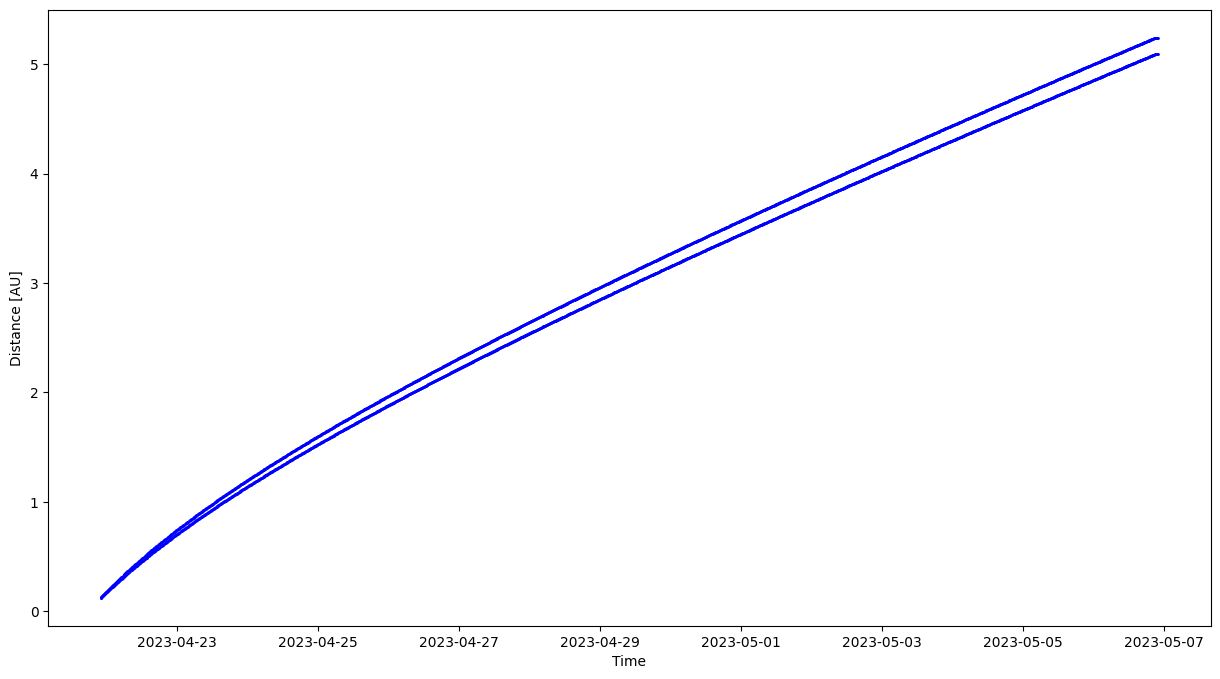

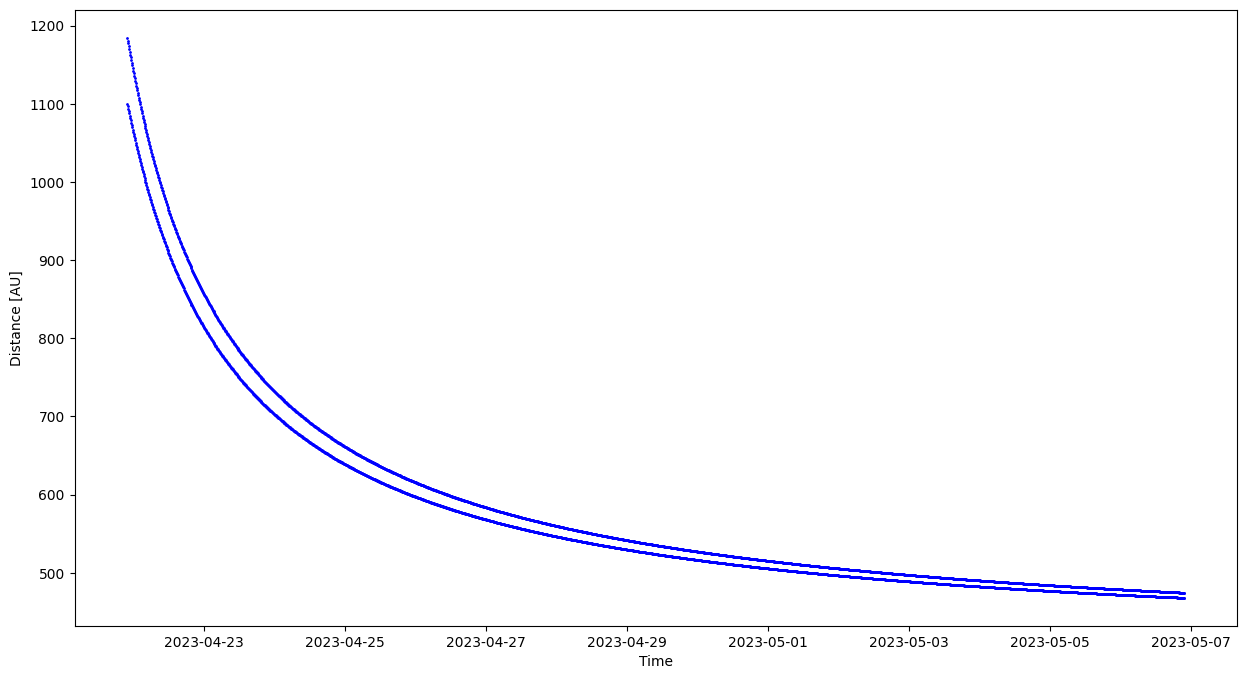

In [21]:
print(hc_arr_time1[0])
plt.figure(1, figsize=(15,8))
plt.plot(mdates.num2date(hc_time_num1), hc_r1[0], 'bo', ms=1)
plt.xlabel('Time')
plt.ylabel('Distance [AU]')

plt.figure(2, figsize=(15,8))
plt.plot(mdates.num2date(hc_time_num1), hc_v1[0], 'bo', ms=1)
#plt.plot(hc_arr_time1[0].plot_date(),[0,800],'-k', lw=0.5, alpha=0.8, color='tab:blue', ms=1)
#plt.plot(hc_arr_time1[1].plot_date(),[0,800],'-k', lw=0.5, alpha=0.8, color='tab:green', ms=1)
plt.xlabel('Time')
plt.ylabel('Distance [AU]')

In [22]:
def make_frame(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((3,2), (0, 0), rowspan=4, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    #print(frame_time_str)
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)
    #print(cmeind1)
    
    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))
                
            if p == 0:
                color = 'tab:blue'
            else: 
                color = 'tab:green'

            ax.plot(longcirc1[0],rcirc1[0], color=color, ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color=color, alpha=.05)
          

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 

    #---------------- NOAA mag

    ax4 = plt.subplot2grid((3,2), (0, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.7, alpha=0.8)
    #ax4.plot_date([hc_arr_time1,hc_arr_time1][0], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:blue')
    #ax4.plot_date([hc_arr_time1,hc_arr_time1][1], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:green')
    #ax4.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:blue')
    #ax4.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:blue')

    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)
        
        for i in range(len(hc_arr_time1)):
            if i == 1:
                color = 'tab:green'
            else:
                color = 'tab:blue'

            ax4.plot_date([hc_arr_time1[i],hc_arr_time1[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
       # for i in range(len(hc_arr_time1)):
        #    if np.isnan(hc_arr_hit1[i]) == False:       
         #       ax4.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
                #ax4.annotate(hc_arr_id1[i][0:16], (hc_arr_time1[i], np.nanmax(n.bt)+5), fontsize=10, rotation=90)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)
       
                


    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((3,2), (1, 1))
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    #ax6.plot_date([hc_arr_time1_sta,hc_arr_time1_sta][0], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:red')
    #ax6.plot_date([hc_arr_time1_sta,hc_arr_time1_sta][1], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:green')
    #ax6.plot_date([hc_err_arr_time_min1_sta,hc_err_arr_time_min1_sta], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:red')
    #ax6.plot_date([hc_err_arr_time_max1_sta,hc_err_arr_time_max1_sta], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:red')
    for i in range(len(hc_arr_time1)):
        if i == 1:
            color = 'tab:green'
        else:
            color = 'tab:red'
            
        ax6.plot_date([hc_arr_time1_sta[i],hc_arr_time1_sta[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
     #   ax6.axvspan(hc_err_arr_time_min1_sta[i], hc_err_arr_time_max1_sta[i], alpha=0.04, color='tab:red')
        
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
            
            
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((3,2), (2, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    #ax5.plot_date([hc_arr_time1,hc_arr_time1][0], [-1000,1000],'-k', lw=0.7, alpha=0.8, color='tab:blue')
    #ax5.plot_date([hc_arr_time1,hc_arr_time1][1], [-1000,1000],'-k', lw=0.7, alpha=0.8, color='tab:red')
    #ax5.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #ax5.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #for i in range(len(hc_arr_time1)):
     #   ax5.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    for i in range(len(hc_arr_time1)):
        if i == 1:
            color = 'tab:green'
        else:
            color = 'tab:blue'

        ax5.plot_date([hc_arr_time1[i],hc_arr_time1[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
    #ax5.set_xticklabels([])
    
    if np.size(s)>0:
        plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-g',label='V',linewidth=0.7)   


    plt.figtext(0.95,0.77,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    #plt.figtext(0.95,0.40,'SolarOrbiter', color='coral', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.92,0.91,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.91,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.91,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.91,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UTC', ha='center',color=backcolor,fontsize=fsize+6)
    
    plt.figtext(0.02, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.02, 0.1,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.02,0.01/2,r'Austrian Space Weather Office, GeoSphere Austria', fontsize=fsize-4, ha='left',color=backcolor) 
    plt.figtext(0.99,0.01/2,'helioforecast.space', fontsize=fsize-4, ha='right',color=backcolor) 
    
    logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    newax.imshow(logo)
    newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)

    #save figure
    framestr = '%05i' % (k)
    filename='output/frames/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')


    plt.close('all')


In [23]:
def make_frame2(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((3,2), (0, 0), rowspan=4, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    print(frame_time_str)
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)

    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))
                
            if p == 0:
                color = 'tab:blue'
            else: 
                color = 'tab:green'

            ax.plot(longcirc1[0],rcirc1[0], color=color, ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color=color, alpha=.05)
          

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 

    #---------------- NOAA mag

    ax4 = plt.subplot2grid((3,2), (0, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.7, alpha=0.8)
    #ax4.plot_date([hc_arr_time1,hc_arr_time1][0], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:blue')
    #ax4.plot_date([hc_arr_time1,hc_arr_time1][1], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:green')
    #ax4.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:blue')
    #ax4.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:blue')

    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)
        
        for i in range(len(hc_arr_time1)):
            if i == 1:
                color = 'tab:green'
            else:
                color = 'tab:blue'

            ax4.plot_date([hc_arr_time1[i],hc_arr_time1[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
       # for i in range(len(hc_arr_time1)):
        #    if np.isnan(hc_arr_hit1[i]) == False:       
         #       ax4.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
                #ax4.annotate(hc_arr_id1[i][0:16], (hc_arr_time1[i], np.nanmax(n.bt)+5), fontsize=10, rotation=90)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)
       
                


    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((3,2), (1, 1))
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    #ax6.plot_date([hc_arr_time1_sta,hc_arr_time1_sta][0], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:red')
    #ax6.plot_date([hc_arr_time1_sta,hc_arr_time1_sta][1], [-1000,1000],'-', lw=0.7, alpha=0.8, color='tab:green')
    #ax6.plot_date([hc_err_arr_time_min1_sta,hc_err_arr_time_min1_sta], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:red')
    #ax6.plot_date([hc_err_arr_time_max1_sta,hc_err_arr_time_max1_sta], [-1000,1000],'-', lw=0.5, alpha=0.4, color='tab:red')
    for i in range(len(hc_arr_time1)):
        if i == 1:
            color = 'tab:green'
        else:
            color = 'tab:red'
            
        ax6.plot_date([hc_arr_time1_sta[i],hc_arr_time1_sta[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
     #   ax6.axvspan(hc_err_arr_time_min1_sta[i], hc_err_arr_time_max1_sta[i], alpha=0.04, color='tab:red')
        
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
            
            
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((3,2), (2, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    #ax5.plot_date([hc_arr_time1,hc_arr_time1][0], [-1000,1000],'-k', lw=0.7, alpha=0.8, color='tab:blue')
    #ax5.plot_date([hc_arr_time1,hc_arr_time1][1], [-1000,1000],'-k', lw=0.7, alpha=0.8, color='tab:red')
    #ax5.plot_date([hc_err_arr_time_min1,hc_err_arr_time_min1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #ax5.plot_date([hc_err_arr_time_max1,hc_err_arr_time_max1], [-1000,1000],'-k', lw=0.5, alpha=0.4, color='tab:blue')
    #for i in range(len(hc_arr_time1)):
     #   ax5.axvspan(hc_err_arr_time_min1[i], hc_err_arr_time_max1[i], alpha=0.04, color='tab:blue')
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    for i in range(len(hc_arr_time1)):
        if i == 1:
            color = 'tab:green'
        else:
            color = 'tab:blue'

        ax5.plot_date([hc_arr_time1[i],hc_arr_time1[i]], [-1000,1000],'-', lw=0.9, alpha=0.8, color=color)
    #ax5.set_xticklabels([])
    
    if np.size(s)>0:
        plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-g',label='V',linewidth=0.7)   


    plt.figtext(0.95,0.77,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    #plt.figtext(0.95,0.40,'SolarOrbiter', color='coral', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.92,0.91,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.91,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.91,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.91,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UTC', ha='center',color=backcolor,fontsize=fsize+6)
    
    plt.figtext(0.02, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.02, 0.1,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.02,0.01/2,r'Austrian Space Weather Office, GeoSphere Austria', fontsize=fsize-4, ha='left',color=backcolor) 
    plt.figtext(0.99,0.01/2,'helioforecast.space', fontsize=fsize-4, ha='right',color=backcolor) 
    
    logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    newax.imshow(logo)
    newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)

   
    #save figure
    #framestr = '%05i' % (k)  
    #filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)

    #plt.close('all')

    ########################################### loop end


In [24]:
get_data=1
if get_data > 0:

    ########## NOAA
    print('load NOAA data GSM')
    file='wind_gsm.p'
    n1=pickle.load(open('data/'+file, "rb" ) ) 

    
    ########### STA GSM
    print('load STEREO-A data GSM')
    filesta1='sta_beacon_gsm.p'
    s=pickle.load(open('data/'+filesta1, "rb" ) )  

    #cut with 2021 January 1st
    scut=np.where(s.time> parse_time('2020-01-01').datetime)[0][0]

    s1=s[scut:-1]
    
    n_time_num=parse_time(n1.time).plot_date
    s_time_num=parse_time(s1.time).plot_date


print('done')

load NOAA data GSM
load STEREO-A data GSM
done


In [25]:
plt.close('all')

print('Define settings')

#Coordinate System
#frame='HCI'
frame='HEEQ'
#print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

AUkm=149597870.7   

#black background on or off
#black=True
black=False

#animation settings
plot_orbit=True
#plot_orbit=False
#plot_parker=True
plot_parker=False

high_res_mode=False

format_str = '%Y-%m-%d'  
format_str_minutes = '%Y-%m-%d %H:%M'
date_today_hour = datetime.now().strftime(format_str)

outputdirectory='output/frames'#+str(date_today_hour)
animdirectory='output/'
t_start = mdates.num2date(data_donki.time21_5[index]).replace(microsecond=0, second=0, minute=0)#.strftime(format_str_minutes)
t_end  = (sc_icme_start_time).replace(microsecond=0, second=0, minute=0)+timedelta(days=2)
print(t_start)
#res_in_days=1/72. #every 20min
res_in_days=1/144. #every 10min
#res_in_days=1/1440. # every minute
#res_in_days=1/24. #every hour

#make time range to see how much frames are needed 
starttime = parse_time(t_start)
endtime = parse_time(t_end)
alltimes = []
while starttime < endtime:
    alltimes.append(starttime)
    starttime += timedelta(days=res_in_days)
k_all=np.size(alltimes)

print('# frames: ', k_all)

#print(date_today_hour)
days_window=3    #size of in situ timerange

if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)

print('done')

#positions_plot_directory='results/plots_positions/'
#if os.path.isdir(positions_plot_directory) == False: os.mkdir(positions_plot_directory)

#print(k_all)

#print('done')


Define settings
2023-04-21 21:00:00+00:00
# frames:  535
done


Save kinematics plots and overview plot for current time
2023-04-21 21:00:00+00:00
2023-04-21 22:40:00+00:00
done


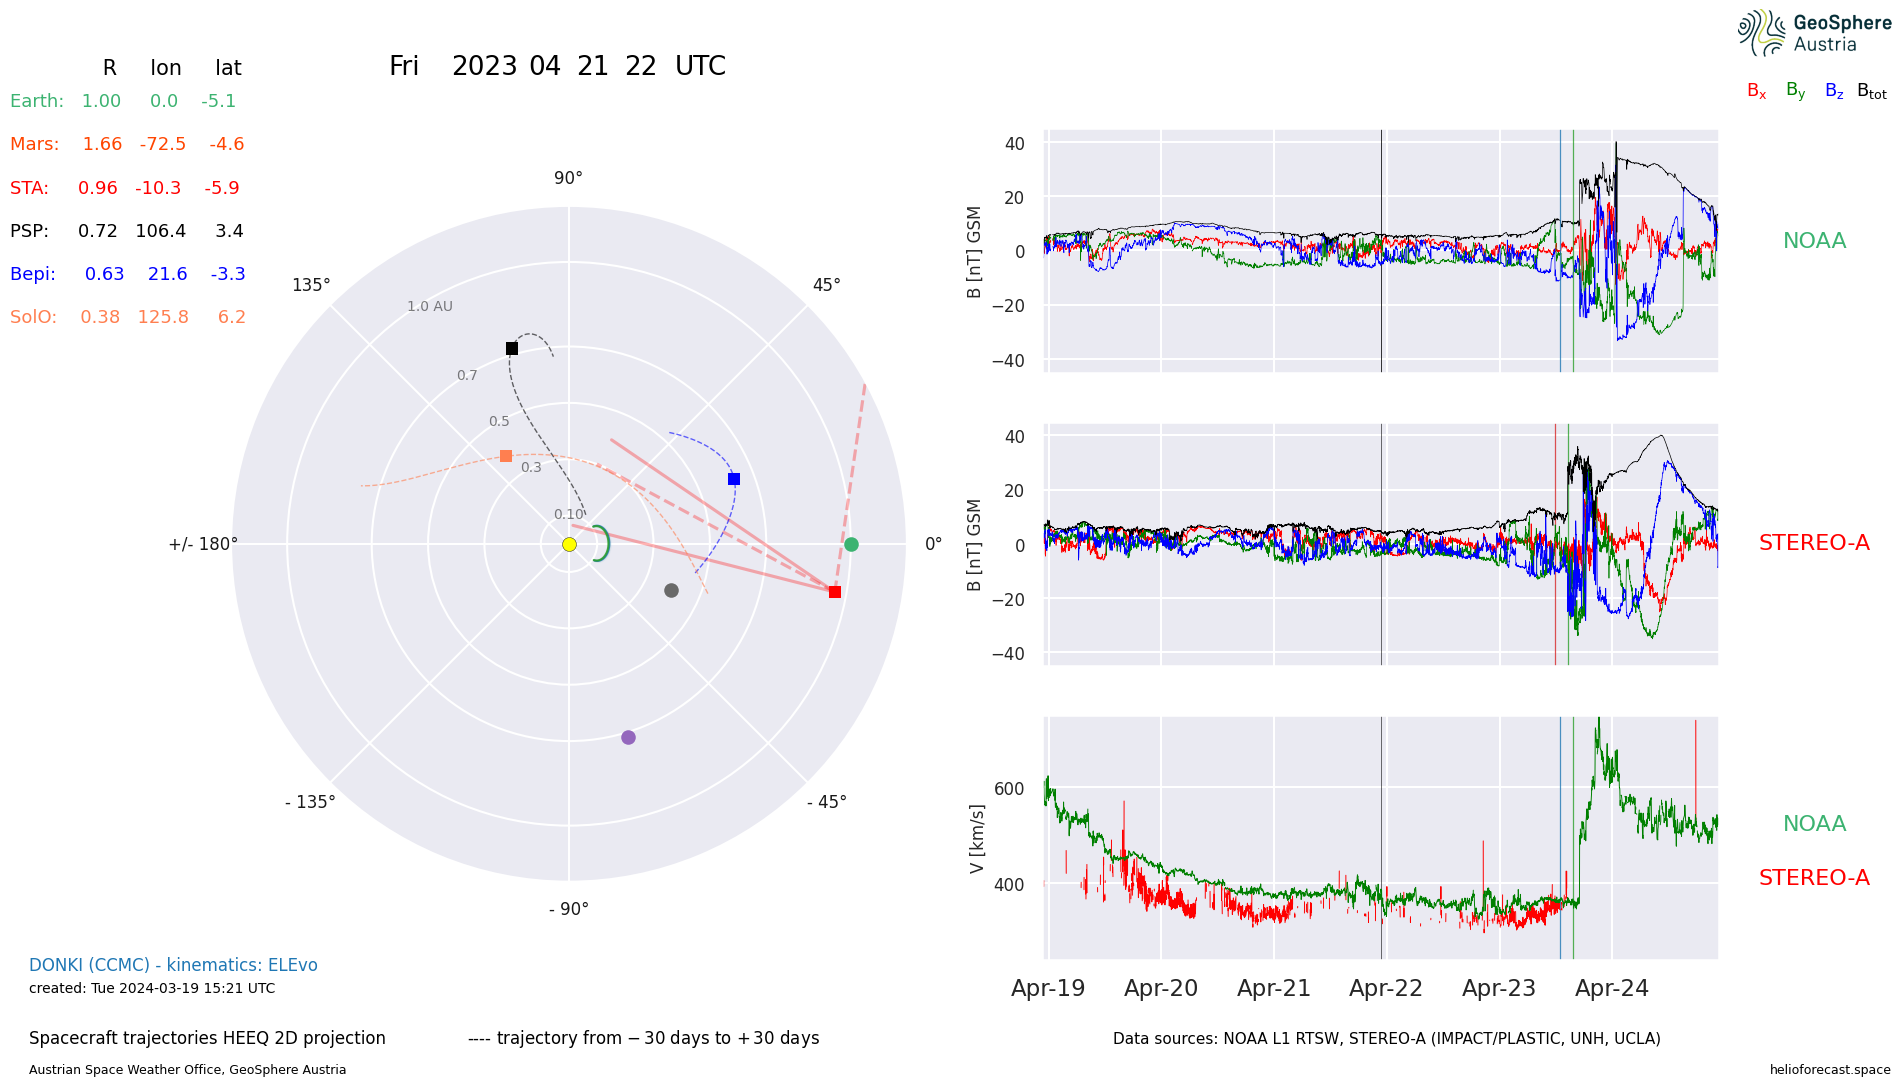

In [26]:
#for server
#matplotlib.use('Qt5Agg')

print('Save kinematics plots and overview plot for current time')

%matplotlib inline

start_time=time.time()

#print()
#print('make animation')

#animation start time in matplotlib format

frame_time_num=parse_time(t_start).plot_date
#print(mdates.num2date(frame_time_num+res_in_days))

frame_time_num_list = [frame_time_num+k*res_in_days for k in range(k_all)]
print(mdates.num2date(frame_time_num_list[0]))

k_today = np.where(frame_time_num_list==mdates.date2num(datetime.now().replace(microsecond=0, second=0, minute=0)))

#print(k_today)

sns.set_context('talk')
if not black: sns.set_style('darkgrid'),#{'grid.linestyle': ':', 'grid.color': '.35'}) 
if black: sns.set_style('white',{'grid.linestyle': ':', 'grid.color': '.35'})   

# animation settings 

fsize=13
fadeind = 200*24 #if s/c positions are given in hourly resolution
#fadeind=int(20/res_in_days)#
#fadeind=int(120/res_in_days)

symsize_planet=110
symsize_spacecraft=80

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

######################## make frames

#for debugging
#don't close plot in make_frame when testing

#plot_kinematics(hc_time_num1, hc_r1, hc_v1)
####################### plot and save frame with todays date and hour 
#make_frame3(k_today[0][0]) 

####################### test animation frames (different frame numbers)
make_frame2(10)#k_today[0][0])

#for i in np.arange(1,3,1):
#    make_frame(i)

print('done') 


In [27]:
t_start = sc_icme_start_time-timedelta(days=2)
t_end = sc_icme_start_time+timedelta(days=2)

l1_pos = l1[np.where((t_start<=l1.time) & (l1.time<t_end))]

In [28]:
print(sc_icme_start_time)
print(hc_arr_time1)

2023-04-23 14:29:00
[datetime.datetime(2023, 4, 23, 12, 49, tzinfo=datetime.timezone.utc)
 datetime.datetime(2023, 4, 23, 15, 39, tzinfo=datetime.timezone.utc)]


In [29]:
time_shift_hours = (parse_time(hc_arr_time1) - parse_time(sc_icme_start_time)).sec/3600
time_shift_err0 = (parse_time(hc_err_arr_time_min1) - parse_time(sc_icme_start_time)).sec/3600
time_shift_err1 = (parse_time(hc_err_arr_time_max1) - parse_time(sc_icme_start_time)).sec/3600

time_shift_hours[time_shift_hours<0] = 0

lower_error_time = np.append(-time_shift_hours,-0.5)
upper_error_time = np.append(time_shift_err1/2, 0.5)
time_shift_hours = np.append(time_shift_hours, measured_time_shift)

time_error = np.array(list(zip(lower_error_time, upper_error_time)))
print(time_error)

hc_arr_speed1_dst = np.append(hc_arr_speed1, hc_arr_speed1[-1])

hc_err_arr_speed1_dst = np.append(hc_err_arr_speed1/2, hc_err_arr_speed1[-1]/2)
print(hc_arr_speed1_dst, hc_err_arr_speed1_dst)


[[-0.          5.        ]
 [-1.16666667  6.58333333]
 [-0.5         0.5       ]]
[806.12812908 756.21707534 756.21707534] [133.35841354 119.44618593 119.44618593]


Processing event  1
Half of ensemble done
Processing event  2
Half of ensemble done
Processing event  3
Half of ensemble done
time in min:  1.0
done


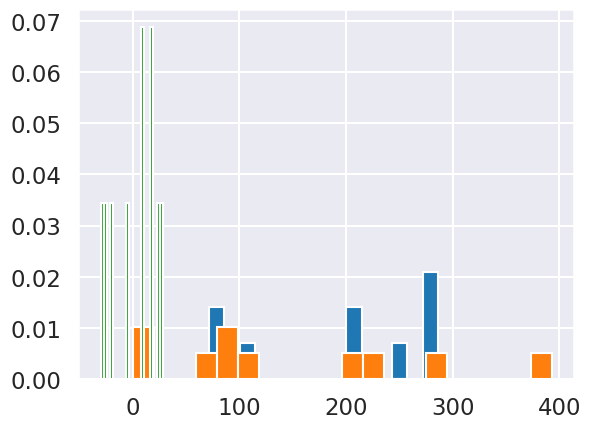

In [31]:
%matplotlib inline
sta_all = []
symh_mean_all = []
speed_mean_all = []
btot_mean_all = []
bz_mean_all = []
speed_std_list = []
btot_std_list = []
bz_std_list = []

time_mean_list = []
symh_mean_list = []
speed_mean_list = []
btot_mean_list = []
bz_mean_list = []
symh_list = []
speed_list = []
btot_list = []
bz_list = []
symh_list_fin = []
btot_err_test = []
btot_err_test1 = []
time_all = []
symh_std_all = []
speed_std_all = []
btot_std_all = []
bz_std_all = []


from scipy import stats as st

start_time=time.time()

for i in range(3):
    
    print('Processing event ', i+1)
    
    n_ensembles = 10
    
    sta_cp = copy.deepcopy(sc_0)
    sta_cp.cut(starttime=t_start, endtime=t_end)
    
    speed = np.ones(len(l1_pos))
    speed[l1_pos.time<sc_icme_start_time] = 400.
    speed[l1_pos.time>=sc_icme_start_time] = hc_arr_speed1_dst[i]
    #ta_cp['speed'] = speed
    
    err_speed = np.ones(len(l1_pos))
    err_speed[l1_pos.time<sc_icme_start_time] = 50.
    err_speed[l1_pos.time>=sc_icme_start_time] = hc_err_arr_speed1_dst[i]
    
    sta_cp.shift_wind_to_L1(l1_pos[i])

    random_time_shift = np.random.randint(time_error[i][0]*60, time_error[i][1]*60, size=n_ensembles)
    #random_time_shift = np.random.normal(0, (hc_arr_time_err1[i]/4)*60, n_ensembles)  
    random_time_shift = np.round(random_time_shift,0) # time shift in minutes
    
    
    plt.hist(random_time_shift, 20, density=True)
    
    speed_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(speed, err_speed/2.)]) 
    speed_array = np.transpose(np.abs(speed_array))
    
    btot_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_cp['btot'], sta_cp['btot_err'])]) 
    btot_array = np.transpose(btot_array)
    
    bx_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_cp['bx'], sta_cp['bx_err'])]) 
    bx_array = np.transpose(bx_array)
    
    by_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_cp['by'], sta_cp['by_err'])]) 
    by_array = np.transpose(by_array)
    
    bz_array = np.array([np.random.normal(k, m, n_ensembles) for k,m in zip(sta_cp['bz'], sta_cp['bz_err'])]) 
    bz_array = np.transpose(bz_array)
    
    density_array = np.array(np.abs(np.random.normal(5, 3, n_ensembles)))

    sta_cp_rand = copy.deepcopy(sta_cp)
    shifted_time_array = sta_cp['time'] + time_shift_hours[i]/24.
    shifted_time_array_date = [mdates.num2date(shifted_time_array[k]).replace(tzinfo=None) for k in range(len(shifted_time_array))]
    #print(shifted_time_array_date)

    for x in range(len(random_time_shift)):
        if x == n_ensembles/2:
            print('Half of ensemble done')
        #print('ensemble: ', x)
        
        sta_cp_rand = copy.deepcopy(sta_cp)
        random_shifted_time_array = shifted_time_array + random_time_shift[x]/60./24.
        random_shifted_time_array_date = [mdates.num2date(random_shifted_time_array[k]).replace(tzinfo=None) for k in range(len(random_shifted_time_array))]
        
        sta_cp_rand['time'] = random_shifted_time_array
        sta_cp_rand['speed'] = speed_array[x]
        sta_cp_rand['btot'] = btot_array[x]
        sta_cp_rand['bx'] = bx_array[x]
        sta_cp_rand['by'] = by_array[x]
        sta_cp_rand['bz'] = bz_array[x]
        sta_cp_rand['density'] = density_array[x]
        sta_cp_rand['dst'] = sta_cp_rand.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst'] #calculate Dst using Temerin-Li 2006 method
        
        sta_cp_rand_dst = copy.deepcopy(sta_cp_rand['dst'])
        
        mask = [np.isin(random_shifted_time_array_date, shifted_time_array_date)][0]
        
        time_mean_list.append(random_shifted_time_array)
        speed_mean_list.append(speed_array[x])
        btot_mean_list.append(btot_array[x])
        bz_mean_list.append(bz_array[x])
        symh_mean_list.append(sta_cp_rand_dst)
        
        
        index_shift = len(mask[mask==False])

        if mask[0] == True:
            
            speed_array1 = copy.deepcopy(speed_array[x])
            speed_shifted = np.roll(speed_array1, index_shift)
            speed_array1[mask] = speed_shifted[mask]
            
            btot_array1 = copy.deepcopy(btot_array[x])
            btot_shifted = np.roll(btot_array1, index_shift)
            btot_array1[mask] = btot_shifted[mask]
            
            bz_array1 = copy.deepcopy(bz_array[x])
            bz_shifted = np.roll(bz_array1, index_shift)
            bz_array1[mask] = bz_shifted[mask]
            
            dst_array1 = copy.deepcopy(sta_cp_rand_dst)
            dst_shifted = np.roll(dst_array1, index_shift)
            dst_array1[mask] = dst_shifted[mask]  
            
        else:
            speed_array1 = copy.deepcopy(speed_array[x])
            speed_shifted = np.roll(speed_array1, -index_shift)
            speed_array1[mask] = speed_shifted[mask]
            
            btot_array1 = copy.deepcopy(btot_array[x])
            btot_shifted = np.roll(btot_array1, -index_shift)
            btot_array1[mask] = btot_shifted[mask]
            
            bz_array1 = copy.deepcopy(bz_array[x])
            bz_shifted = np.roll(bz_array1, -index_shift)
            bz_array1[mask] = bz_shifted[mask]
            
            dst_array1 = copy.deepcopy(sta_cp_rand_dst)
            dst_shifted = np.roll(dst_array1, -index_shift)
            dst_array1[mask] = dst_shifted[mask] 
        
        speed_list.append(speed_array1)
        btot_list.append(btot_array1)
        bz_list.append(bz_array1)
        symh_list.append(dst_array1)
        
        
    symh_mean_unshifted = np.mean(symh_mean_list, axis=0)
    symh_std_unshifted = np.std(symh_mean_list,axis=0)
    speed_mean_unshifted = np.mean(speed_mean_list, axis=0)
    speed_std_unshifted = np.std(speed_mean_list, axis=0)
    btot_mean_unshifted = np.mean(btot_mean_list,axis=0)
    btot_std_unshifted = np.std(btot_mean_list,axis=0)
    bz_mean_unshifted = np.mean(bz_mean_list, axis=0)
    bz_std_unshifted = np.std(bz_mean_list, axis=0)

    symh_mean = np.mean(symh_list, axis=0)
    symh_std = np.std(symh_list,axis=0)
    speed_mean = np.mean(speed_list, axis=0)
    speed_std = np.std(speed_list, axis=0)
    btot_mean = np.mean(btot_list,axis=0)
    btot_std = np.std(btot_list,axis=0)
    bz_mean = np.mean(bz_list, axis=0)
    bz_std = np.std(bz_list, axis=0)
    
    #sta_cp_shifted = copy.deepcopy(sta_cp)
    #sta_cp_shifted['time'] = shifted_time_array #np.mean(time_mean_list,axis=0) #shifted_time_array
    #sta_cp_shifted['speed'] = speed_mean_unshifted #np.mean(speed_mean_list,axis=0) #sta_cp['speed'] #np.mean(speed_mean_list) #
    #sta_cp_shifted['speed_err'] = 2*np.sqrt(speed_std**2+speed_std_unshifted**2)#2*speed_std
    #sta_cp_shifted['dst'] = symh_mean_unshifted#np.mean(symh_list_fin)
    #sta_cp_shifted['dst_err'] = 2*np.sqrt(symh_std**2+symh_std_unshifted**2)
    #sta_cp_shifted['btot'] = btot_mean_unshifted #np.mean(btot_mean_list,axis=0) #sta_cp['btot'] #np.mean(btot_mean_list,axis=0) #
    #sta_cp_shifted['btot_err'] = 2*np.sqrt(btot_std**2+btot_std_unshifted**2)#2*btot_std
    #sta_cp_shifted['bz'] = bz_mean_unshifted #np.mean(bz_mean_list,axis=0) #sta_cp['bz'] #np.mean(bz_mean_list,axis=0) #
    #sta_cp_shifted['bz_err'] = 2*np.sqrt(bz_std**2+bz_std_unshifted**2)#2*bz_std
    
    time_all.append(shifted_time_array)
    symh_mean_all.append(symh_mean_unshifted)
    speed_mean_all.append(speed_mean_unshifted)
    btot_mean_all.append(btot_mean_unshifted)
    bz_mean_all.append(bz_mean_unshifted)
    symh_std_all.append(2*np.sqrt(symh_std**2+symh_std_unshifted**2))
    speed_std_all.append(2*np.sqrt(speed_std**2+speed_std_unshifted**2))
    btot_std_all.append(2*np.sqrt(btot_std**2+btot_std_unshifted**2))
    bz_std_all.append(2*np.sqrt(bz_std**2+bz_std_unshifted**2))
    


print('time in min: ',np.round((time.time()-start_time)/60))
print('done')

In [34]:
file_name = sc_icme_start_time.strftime('%Y%m%d_%H%M')
    
rmse_all = []
mae_all = []
for i in range(3):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(13,12), sharex=True)
    
    wind_cp = copy.deepcopy(wind_0)
    omni_cp = copy.deepcopy(omni_0)
    wind_cp['dst'] = wind_cp.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
    
    wind_cp.cut(starttime=mdates.num2date(time_all[i][0]), endtime=mdates.num2date(time_all[i][-1])+timedelta(minutes=1))
    omni_cp.cut(starttime=mdates.num2date(time_all[i][0]), endtime=mdates.num2date(time_all[i][-1])+timedelta(minutes=1))

    ax1.plot(mdates.num2date(wind_cp['time']), wind_cp['btot'], label=r'Wind B$_{\mathrm{tot}}$', c='blue')
    ax1.plot(mdates.num2date(time_all[i]), btot_mean_all[i], label=r'STEREO-A B$_{\mathrm{tot}}$', c='red')
    ax1.errorbar(mdates.num2date(time_all[i]), btot_mean_all[i], yerr=btot_std_all[i], c='red', alpha=0.01)
    ax1.set_ylabel(r'B$_{\mathrm{tot}}$ [nT]')
    ax1.legend(loc='upper left')

    ax2.plot(mdates.num2date(wind_cp['time']), wind_cp['bz'], label=r'Wind B$_{\mathrm{z}}$', c='blue')
    ax2.plot(mdates.num2date(time_all[i]), bz_mean_all[i], label=r'STEREO-A B$_{\mathrm{z}}$', c='red')
    ax2.errorbar(mdates.num2date(time_all[i]), bz_mean_all[i], yerr=bz_std_all[i], c='red', alpha=0.01)
    ax2.set_ylabel(r'B$_{\mathrm{z}}$ [nT]')
    ax2.legend(loc='upper left')

    ax3.plot(mdates.num2date(wind_cp['time']), wind_cp['speed'], label='Wind speed', c='blue')
    ax3.plot(mdates.num2date(time_all[i]), speed_mean_all[i], label='STEREO-A speed ', c='red')
    ax3.errorbar(mdates.num2date(time_all[i]), speed_mean_all[i], yerr=speed_std_all[i], c='red', alpha=0.01)
    ax3.set_ylabel('speed [km s$^{-1}$]')
    ax3.legend(loc='upper left')

    ax4.plot(mdates.num2date(omni_cp['time']), omni_cp['symh'], label='OMNI SYM-H (obs)', c='black')
    ax4.plot(mdates.num2date(wind_cp['time']), wind_cp['dst'], label='Wind SYM-H (calc)', c='blue')
    ax4.plot(mdates.num2date(time_all[i]), symh_mean_all[i], label='STEREO-A SYM-H (calc)', c='red')
    ax4.errorbar(mdates.num2date(time_all[i]), symh_mean_all[i], yerr=symh_std_all[i], c='red', alpha=0.01)
    ax4.set_ylabel('SYM-H')
    ax4.legend(loc='lower left')
    
    ax5.plot(mdates.num2date(time_all[i]), (omni_cp['symh']-symh_mean_all[i]), label='STEREO-A SYM-H (calc)', c='grey')
    ax5.set_ylabel(r'$\Delta$ SYM-H')
    
    plt.xlim(time_all[i][1500],time_all[i][-100])
    fig.tight_layout()

    plt.savefig('figures/sub_l1_'+file_name+'_1000_ensembles'+str(i)+'.png')
    plt.close()
    
    rmse = np.round(np.sqrt(np.sum((omni_cp['symh']-symh_mean_all[i])**2)/len(omni_cp['symh'])),2)
    mae = np.round(1/len(omni_cp['symh'])*np.sum(np.abs(omni_cp['symh']-symh_mean_all[i])),2)
    print(rmse)
    print(mae)
    rmse_all.append(rmse)
    mae_all.append(mae)

48.9
41.2
47.45
39.62
47.62
38.02


In [36]:
file_name = sc_icme_start_time.strftime('%Y%m%d_%H%M')
    
rmse_all = []
mae_all = []
for i in range(3):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(13,12), sharex=True)
    
    wind_cp = copy.deepcopy(wind_0)
    omni_cp = copy.deepcopy(omni_0)
    wind_cp['dst'] = wind_cp.make_dst_prediction(method='temerin_li_2006', t_correction=True)['dst']
    
    wind_cp.cut(starttime=mdates.num2date(sta_all[i]['time'][0]), endtime=mdates.num2date(sta_all[i]['time'][-1])+timedelta(minutes=1))
    omni_cp.cut(starttime=mdates.num2date(sta_all[i]['time'][0]), endtime=mdates.num2date(sta_all[i]['time'][-1])+timedelta(minutes=1))

    ax1.plot(mdates.num2date(wind_cp['time']), wind_cp['btot'], label=r'Wind B$_{\mathrm{tot}}$', c='blue')
    ax1.plot(mdates.num2date(sta_all[i]['time']), sta_all[i]['btot'], label=r'STEREO-A B$_{\mathrm{tot}}$', c='red')
    #ax1.plot(mdates.num2date(sta_all[i]['time']), btot_err_test[i], label=r'STEREO-A B$_{\mathrm{tot}}$', c='gray', lw=0.7)
    #ax1.plot(mdates.num2date(sta_all[i]['time']), btot_err_test1[i], label=r'STEREO-A B$_{\mathrm{tot}}$', c='gray', lw=0.7)
    #ax1.plot(mdates.num2date(sta_all[i]['time']), btot_mean_all[i], label=r'STEREO-A B$_{\mathrm{tot}}$', c='red', lw=0.7)
    ax1.errorbar(mdates.num2date(sta_all[i]['time']), sta_all[i]['btot'], yerr=sta_all[i]['btot_err'], c='red', alpha=0.01)
    #ax1.errorbar(mdates.num2date(sta_all[i]['time']), btot_mean_all[i], yerr=sta_all[i]['btot_err'], c='red', alpha=0.01)
    ax1.set_ylabel(r'B$_{\mathrm{tot}}$ [nT]')
    ax1.legend(loc='upper left')

    ax2.plot(mdates.num2date(wind_cp['time']), wind_cp['bz'], label=r'Wind B$_{\mathrm{z}}$', c='blue')
    ax2.plot(mdates.num2date(sta_all[i]['time']), sta_all[i]['bz'], label=r'STEREO-A B$_{\mathrm{z}}$', c='red')
    #ax2.plot(mdates.num2date(sta_all[i]['time']), bz_mean_all[i], label=r'STEREO-A B$_{\mathrm{tot}}$', c='red', lw=0.7)
    ax2.errorbar(mdates.num2date(sta_all[i]['time']), sta_all[i]['bz'], yerr=sta_all[i]['bz_err'], c='red', alpha=0.01)
    #ax2.errorbar(mdates.num2date(sta_all[i]['time']), bz_mean_all[i], yerr=sta_all[i]['bz_err'], c='red', alpha=0.01)
    ax2.set_ylabel(r'B$_{\mathrm{z}}$ [nT]')
    ax2.legend(loc='upper left')

    ax3.plot(mdates.num2date(wind_cp['time']), wind_cp['speed'], label='Wind speed', c='blue')
    ax3.plot(mdates.num2date(sta_all[i]['time']), sta_all[i]['speed'], label='STEREO-A speed ', c='red')
    ax3.errorbar(mdates.num2date(sta_all[i]['time']), sta_all[i]['speed'], yerr=sta_all[i]['speed_err'], c='red', alpha=0.01)
    #ax3.errorbar(mdates.num2date(sta_all[i]['time']), speed_mean_all[i], yerr=sta_all[i]['speed_err'], c='red', alpha=0.01)
    ax3.set_ylabel('speed [km s$^{-1}$]')
    ax3.legend(loc='upper left')

    ax4.plot(mdates.num2date(omni_cp['time']), omni_cp['symh'], label='OMNI SYM-H (obs)', c='black')
    #ax4.plot(mdates.num2date(omni_cp['time']), omni_cp['dst'], label='OMNI SYM-H (obs)', c='gray')
    ax4.plot(mdates.num2date(wind_cp['time']), wind_cp['dst'], label='Wind SYM-H (calc)', c='blue')
    ax4.plot(mdates.num2date(sta_all[i]['time']), sta_all[i]['dst'], label='STEREO-A SYM-H (calc)', c='red')
    #ax4.errorbar(mdates.num2date(sta_all[i]['time']), sta_all[i]['dst'], yerr=sta_all[i]['dst_err'], c='red', alpha=0.01)
    ax4.errorbar(mdates.num2date(sta_all[i]['time']), symh_mean_all[i], yerr=sta_all[i]['dst_err'], c='red', alpha=0.01)
    ax4.set_ylabel('SYM-H')
    ax4.legend(loc='lower left')
    
    ax5.plot(mdates.num2date(sta_all[i]['time']), (omni_cp['symh']-sta_all[i]['dst']), label='STEREO-A SYM-H (calc)', c='grey')
    #ax5.errorbar(mdates.num2date(sta_all[i]['time']), (omni_cp['symh']-sta_all[i]['dst']), yerr=sta_all[i]['dst_err'], c='grey', alpha=0.01)
    ax5.set_ylabel(r'$\Delta$ SYM-H')
    #ax5.legend(loc='lower left')
    
    plt.xlim(sta_all[i]['time'][1500],sta_all[i]['time'][-100])
    fig.tight_layout()

    plt.savefig('figures/sub_l1_'+file_name+'_1000_ensembles'+str(i)+'.png')
    plt.close()
    
    rmse = np.sqrt(np.sum((omni_cp['symh']-sta_all[i]['dst'])**2)/len(omni_cp['symh']))
    mae = 1/len(omni_cp['symh'])*np.sum(np.abs(omni_cp['symh']-sta_all[i]['dst']))
    print(rmse)
    print(mae)
    rmse_all.append(rmse)
    mae_all.append(mae)

47.14527414528551
39.658483095490205
46.17054180035534
38.454796257139414
47.36178437003098
37.743640038523075


In [50]:
import multiprocessing
import multiprocess as mp
matplotlib.use('Agg')

print('Creating ', k_all,' frames')

print()

start_time=time.time()

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=1
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number

pool=mp.get_context('fork').Pool(processes=used)

#pool = mp.Pool(processes=nr_of_processes_used)
#input=[i for i in range(k_all)]
input=[i for i in np.arange(1,k_all,1)]
pool.map(make_frame, input)
pool.close()
pool.join()
#for i in input:
 #   make_frame2(i)

print('time in min: ',np.round((time.time()-start_time)/60))
print('plots done, frames saved')

Creating  535  frames

Using multiprocessing, nr of cores 128 with nr of processes used:  1
time in min:  10.0
plots done, frames saved


In [51]:
ffmpeg_path=''

os.system(ffmpeg_path+'ffmpeg -r 30 -i output/frames/pos_anim_%05d.jpg -b 5000k \
    -r 30 output/elevo_real_time_'+file_name+'.mp4 -y -loglevel warning') 

print('movie done & saved')

Please use -b:a or -b:v, -b is ambiguous


movie done & saved
